# Neutrino event classification

This mini-project's dataset is comprised of a number of small files containing images of simulated neutrino interactions in a hypothetical detector that looks an awful lot like the detectors of the NOvA experiment. For each neutrino interaction the images consist of two $100 \times 80$ pixel images that represent the $x \times z$ and $y \times z$ projections of the tracks of particles in the detector.

The data for this mini-project comes in the form of the following files:

| File | Description |
| ----------- | ----------- |
| neutrino1.h5 | The 1st HDF5 file containing event images and meta deta |
| $\vdots$ | The middle ones |
| neutrino200.h5| The 200th HDF5 file|


The images show the energy deposited by simulated neutrinos in a NOvA like detector. Some of the meta information in the hdf5 file is described below

| Label | Description |
| ----------- | ----------- |
| neutrino/nuenergy | Neutrino Energy (GeV) |
| neutrino/lepenergy | Lepton Energy (GeV) |
| neutrino/finalstate | Interaction |
| neutrino/finalstate | Final State |
 

The [PDG code](https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf) is a number which identifies the particle type (e.g electron=11, electron-neutrino=12, etc.)

The $interaction$ says what kind of interaction occured and is defined in the enumeration below.

## Machine learning tasks
1. Develop a machine learning classifier that can successfully identify $\nu_\mu$ charged-current events
2. Test your machine learning classifier and investigate how the efficiency of the classifier depends on the meta data variables shown above

### Potential extensions
1. Write a machine learning algorithm to determine the energy of the neutrino
2. Write a machine learning algorithm to determine the flavour of the neutrino
3. Write a machine learning algorithm to determine $y=$ lepton energy over neutrino energy
4. Write a machine learning algorithm to determine the number of protons or pions
5. Write a machine learning algorithm to determine the interaction mode.




# STUDENT NUMBER 20121702

In [ ]:
# MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!mkdir /content/drive/MyDrive/neutrino_ML

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization,Flatten, Activation, Add, GlobalAveragePooling2D, Dense, MaxPooling2D, concatenate, Dropout
from keras.layers import LocallyConnected2D
from keras import callbacks
import os
import keras
from keras import layers
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [ ]:
os.chdir("/content/drive/MyDrive/neutrino_ML")

In [ ]:

import enum 
class Interaction(enum.Enum):
    kNumuQE =0           # Numu CC QE interaction
    kNumuRes =1           # Numu CC Resonant interaction
    kNumuDIS = 2          # Numu CC DIS interaction
    kNumuOther = 3        # Numu CC, other than above
    kNueQE = 4            # Nue CC QE interaction
    kNueRes = 5           # Nue CC Resonant interaction
    kNueDIS = 6           # Nue CC DIS interaction
    kNueOther = 7         # Nue CC, other than above
    kNutauQE = 8          # Nutau CC QE interaction
    kNutauRes = 9         # Nutau CC Resonant interaction
    kNutauDIS =10         # Nutau CC DIS interaction
    kNutauOther =11       # Nutau CC, other than above
    kNuElectronElastic = 12# NC Nu On E Scattering
    kNC =13                # NC interaction
    kCosmic =14           # Cosmic ray background
    kOther =15            # Something else.  Tau?  Hopefully we don't use this
    kNIntType=16          # Number of interaction types, used like a vector size

    
class FinalState(enum.Enum):
    kNumu0tr0sh=0          # Numu CC - no track no shower
    kNumu0tr1sh=1          # Numu CC - no track  1 shower
    kNumu0tr2sh=enum.auto()          # Numu CC - no track  2 shower
    kNumu0trMsh=enum.auto()          # Numu CC - no track 3+ shower
    kNumu1tr0sh=enum.auto()          # Numu CC -  1 track no shower
    kNumu1tr1sh=enum.auto()          # Numu CC -  1 track  1 shower
    kNumu1tr2sh=enum.auto()          # Numu CC -  1 track  2 shower
    kNumu1trMsh=enum.auto()          # Numu CC -  1 track 3+ shower
    kNumu2tr0sh=enum.auto()          # Numu CC -  2 track no shower
    kNumu2tr1sh=enum.auto()          # Numu CC -  2 track  1 shower
    kNumu2tr2sh=enum.auto()          # Numu CC -  2 track  2 shower
    kNumu2trMsh=enum.auto()          # Numu CC -  2 track 3+ shower
    kNumuMtr0sh=enum.auto()          # Numu CC - 3+ track no showe
    kNumuMtr1sh=enum.auto()          # Numu CC - 3+ track  1 shower
    kNumuMtr2sh=enum.auto()          # Numu CC - 3+ track  2 showe
    kNumuMtrMsh=enum.auto()          # Numu CC - 3+ track 3+ shower
    kNue0tr0sh=enum.auto()           # Nue CC - no track no shower
    kNue0tr1sh=enum.auto()           # Nue CC - no track  1 shower
    kNue0tr2sh=enum.auto()           # Nue CC - no track  2 showe
    kNue0trMsh=enum.auto()           # Nue CC - no track 3+ shower
    kNue1tr0sh=enum.auto()           # Nue CC -  1 track no shower
    kNue1tr1sh=enum.auto()           # Nue CC -  1 track  1 shower
    kNue1tr2sh=enum.auto()           # Nue CC -  1 track  2 shower
    kNue1trMsh=enum.auto()           # Nue CC -  1 track 3+ shower
    kNue2tr0sh=enum.auto()           # Nue CC -  2 track no shower
    kNue2tr1sh=enum.auto()           # Nue CC -  2 track  1 shower
    kNue2tr2sh=enum.auto()           # Nue CC -  2 track  2 shower
    kNue2trMsh=enum.auto()           # Nue CC -  2 track 3+ shower
    kNueMtr0sh=enum.auto()           # Nue CC - 3+ track no shower
    kNueMtr1sh=enum.auto()           # Nue CC - 3+ track  1 shower
    kNueMtr2sh=enum.auto()           # Nue CC - 3+ track  2 shower
    kNueMtrMsh=enum.auto()           # Nue CC - 3+ track 3+ shower
    kNC0tr0sh=enum.auto()           # NC CC - no track no shower
    kNC0tr1sh=enum.auto()           # NC CC - no track  1 shower
    kNC0tr2sh=enum.auto()           # NC CC - no track  2 shower
    kNC0trMsh=enum.auto()           # NC CC - no track 3+ shower
    kNC1tr0sh=enum.auto()           # NC CC -  1 track no shower
    kNC1tr1sh=enum.auto()           # NC CC -  1 track  1 shower
    kNC1tr2sh=enum.auto()           # NC CC -  1 track  2 shower
    kNC1trMsh=enum.auto()           # NC CC -  1 track 3+ shower
    kNC2tr0sh=enum.auto()           # NC CC -  2 track no shower
    kNC2tr1sh=enum.auto()           # NC CC -  2 track  1 shower
    kNC2tr2sh=enum.auto()           # NC CC -  2 track  2 shower
    kNC2trMsh=enum.auto()           # NC CC -  2 track 3+ shower
    kNCMtr0sh=enum.auto()           # NC CC - 3+ track no shower
    kNCMtr1sh=enum.auto()           # NC CC - 3+ track  1 shower
    kNCMtr2sh=enum.auto()           # NC CC - 3+ track  2 shower
    kNCMtrMsh=enum.auto()           # NC CC - 3+ track 3+ shower
    kCosmicFS=enum.auto()           # Cosmic ray background
    kOtherFS=enum.auto()            # Something else.  Tau?  Hopefully we don't use this
    kNFStType=enum.auto()            # Number of interaction types, used like a vector size



# Download data from nova project


In [ ]:
# import the urllib library
import urllib.request
 
# Copy a network object to a local file
urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino1.h5', "neutrino1.h5")

#Open the local h5 file with h5py
df=h5py.File('neutrino1.h5','r')

In [ ]:
# import the urllib library


data={} # Empty dictionary

# Loop over first 100 neutrinos and store the info
for i in range(1,100):
    # Copy a network object to a local file
    urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino'+str(i)+'.h5',
                               "neutrino"+str(i)+".h5")
    
    # Open the local h5 file with h5py
    data[i]=h5py.File(f'neutrino'+str(i)+'.h5','r')
    

In [ ]:
#every item in dictionaty df['neutrino']
for i, key in enumerate(df['neutrino'].keys()):
    print(f'{i+1}. {key}')

1. cycle
2. evt
3. finalstate
4. finalstateprong
5. interaction
6. lepenergy
7. nuenergy
8. parent
9. particles
10. rec.training.trainingdata_idx
11. run
12. subevt
13. subrun
14. vtxx
15. vtxy
16. vtxz


# Plot functions for the notebook
Below are some plot functions that can be used to visualize the performance of the event classifier.

In [ ]:
# VISUALISATION OF NEUTRINO TRACKS PLOT FUNCTIONS (TASK_1)
def multi_event_plot(n,neutrino_n):
    '''
    Function to plot n number of events from df['cvnmap']
    Args:
    n ---> Number of events to plot
    neutrino_n ---> Neutrino number (which neutrino will be evaluated)
    Returns:
                    PLOTS
    '''
    #store n-events
    events = np.zeros((n, 2, 100, 80))
    for i in range(n):
        events[i]=np.array(data[neutrino_n]['cvnmap'][i]).reshape((2,100,80))
        fig, ax = plt.subplots(1,2,figsize=(5,4))
        ax[0].imshow(events[i][1].T,cmap='hot')
        ax[0].set_title(f'x-z event{i} for neutrino{neutrino_n}')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('z')
        plt.subplots_adjust(wspace=1.0)
        ax[1].imshow(events[i][0].T,cmap='hot')
        ax[1].set_title(f'y-z event{i} for neutrino{neutrino_n}')
        ax[1].set_xlabel('y')
        ax[1].set_ylabel('z')

        plt.show()

def event_plot(neutrino,event):
    '''
    plot a single track of a neutrino
    '''
    track=np.array(data[neutrino]['cvnmap'][event]).reshape((2,100,80))
    fig, ax = plt.subplots(1,2,figsize=(10,9))
    ax[0].imshow(track[1].T,cmap='hot')
    ax[0].set_title(f'Track x-z of event {event} for neutrino{neutrino}')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('z')
    plt.subplots_adjust(wspace=0.6)
    ax[1].imshow(track[0].T,cmap='hot')
    ax[1].set_title(f'Track y-z of event {event} for neutrino{neutrino}')
    ax[1].set_xlabel('y')
    ax[1].set_ylabel('z')

# VISUALISATION OF MODEL PERFORMANCE (TASK_1 & TASK_2)
def plot_train(history_m):
    fig,ax=plt.subplots(1,2, figsize=(17,5))
    ax[0].plot(history_m.history['binary_accuracy'], linewidth=2, c='#ff9999', label='training')
    ax[0].plot(history_m.history['val_binary_accuracy'], linewidth=3,c='#ffcc99', label='validation')

    # Setting axis and labels
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Plot of Accuray over training Epoch')
    ax[0].legend()
    ax[1].plot(history_m.history['loss'], linewidth=3, c='#ff9999', label='training')
    ax[1].plot(history_m.history['val_loss'], linewidth=3, c='#ffcc99', label='validation')

    # Setting axis and labels
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Plot of Loss over training Epoch')
    ax[1].legend()

    plt.show()

def train_test_visuals(history, model, data_test,lbl_test, split_data=False):
    '''
    oooooooo 
    '''
    if split_data:
        data_test_0 = data_test[:, :, :, 0]
        data_test_1 = data_test[:, :, :, 1]
        plot_train(history)
        predictions = model.predict((data_test_0, data_test_1))
        predictions = np.where(predictions > 0.5, 1, 0)
        conf_matrix = confusion_matrix(lbl_test, predictions)
        sns.heatmap(conf_matrix, annot=True, cmap='Blues')
        plt.title('Confidence Matrix - Split Data')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        #plt.show()
    else:
        plot_train(history)
        predictions = model.predict(data_test)
        predictions = np.where(predictions > 0.5, 1, 0)
        conf_matrix = confusion_matrix(lbl_test, predictions)
        sns.heatmap(conf_matrix, annot=True, cmap='Blues')
        plt.title('Confidence Matrix')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        #plt.show()


def model_metrics(model,test_data,test_lbl,batch_size):

  # Model.predict produce array of predictions (percentage of certainties) 
  y_score = model.predict(test_data, batch_size = batch_size)
  # True values are the labels
  y_true  = test_lbl

  ####################################################################################
  #                              ROC CURVE                                           #
  ####################################################################################

  # Roc curve data and false positives/ true positive rate, using sklearn function
  fpr, tpr, threshold  =  metrics.roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)
  # Plotting ROC and rates for unbalanced data
  fig,ax=plt.subplots(1,2, figsize=(15,5))
  ax[0].plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc,c='black')
  ax[0].plot( threshold, fpr,'--', label = 'True False rate',c='red')
  ax[0].plot( threshold, tpr, '--', label = 'True Positive rate',c='navy')
  ax[0].set_xlim(0,1)
  # Setting axis and labels
  ax[0].set_xlabel('False Positive Rate/ Threshold')
  ax[0].set_ylabel('True Positive Rate/ Rates')
  ax[0].set_title('Plot of ROC curve and False/True Positive rate for Unbalanced data')
  ax[0].legend()
  
  ####################################################################################
  #                          PRECISION RECALL CURVE                                  #
  ####################################################################################

  precision, recall, thresholds = precision_recall_curve(y_true, y_score)
  ap = average_precision_score(y_true, y_score)

  ax[1].plot(recall, precision, color='k', label='Precision-Recall curve (AP = %0.2f)' % ap )
  ax[1].set_xlabel('Recall')
  ax[1].set_ylabel('Precision')
  ax[1].set_ylim([0.0, 1.05])
  ax[1].set_xlim([0.0, 1.0])
  ax[1].set_title('Precision-Recall curve')
  ax[1].legend(loc="lower left")
  plt.show()

# VISUALISATION OF DIFFERENT INTERACTIONS (TASK_2)

def event_plot_by_class(event_inputs, event_interactions, class_id, pos=0):
    '''
    Plot the first occurrence of the given event class in the event_inputs.
    
    Parameters:
    - event_inputs: the input data of shape (num_samples, height, width, channels).
    - event_interactions: the class labels of shape (num_samples,).
    - class_id: the ID of the event class to plot.
    '''
    r = np.where(event_interactions == class_id)[0][pos]
    track_xz = event_inputs[r].transpose(1, 0, 2)[:, :, 0]
    track_yz = event_inputs[r].transpose(1, 0, 2)[:, :, 1]
    fig, ax = plt.subplots(1,2,figsize=(10,9))
    ax[0].imshow(track_xz,cmap='hot')
    ax[0].set_title(f'Track x-z of event {r} for class {class_id}')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('z')
    plt.subplots_adjust(wspace=0.6)
    ax[1].imshow(track_yz,cmap='hot')
    ax[1].set_title(f'Track y-z of event {r} for class {class_id}')
    ax[1].set_xlabel('y')
    ax[1].set_ylabel('z')


*VISUALIZATION/INFO OF NEUTRINO TRACKS OF NOvA EXPERIMENT*

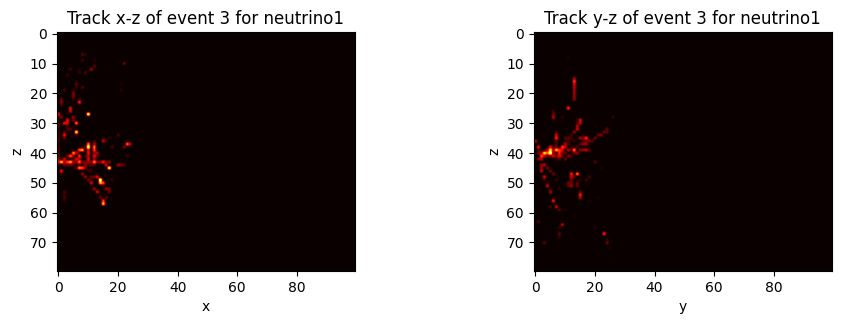

In [ ]:
# Plot the third event of the neutrino1 and it looks like a pion track!
event_n=3
neutrino_n=1
event_plot(neutrino_n,event_n)
plt.savefig('neutrino_event2_neutrino1_pion.png')

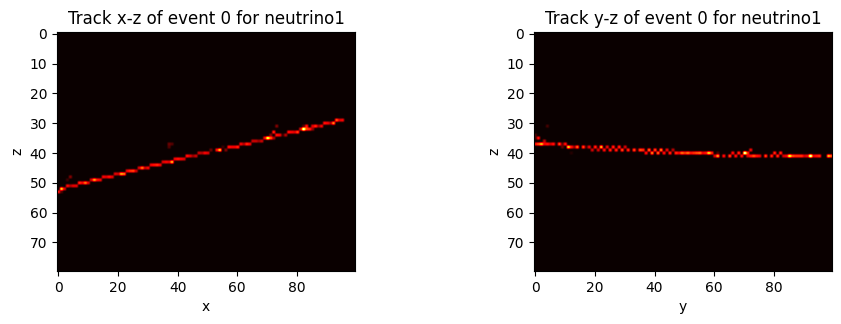

In [ ]:
# Plot the first event of neutrino1 and it looks like a nice long muon track!
event_n=0
neutrino_n=1
event_plot(neutrino_n,event_n)

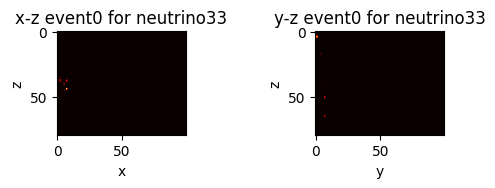

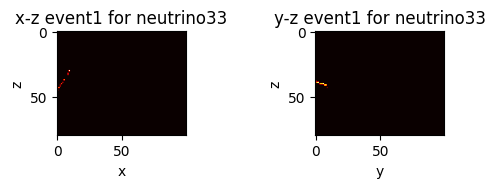

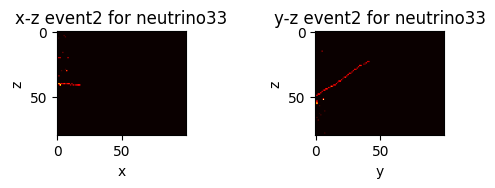

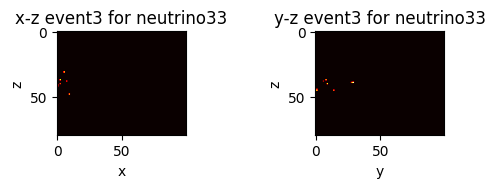

In [ ]:
#Plot the first 4 events of neutrino33!
number_events=4
neutrino_number=33
multi_event_plot(number_events, neutrino_number)


In [ ]:
print("Neutrino Final State code",df['neutrino']['finalstate'][0][0])
print("Interaction was ",Interaction(df['neutrino']['interaction'][0]))
print("Neutrino energy",df['neutrino']['nuenergy'][0][0],"GeV")

Neutrino Final State code 8
Interaction was  Interaction.kNumuQE
Neutrino energy 33.076805 GeV


Text(0, 0.5, 'Count')

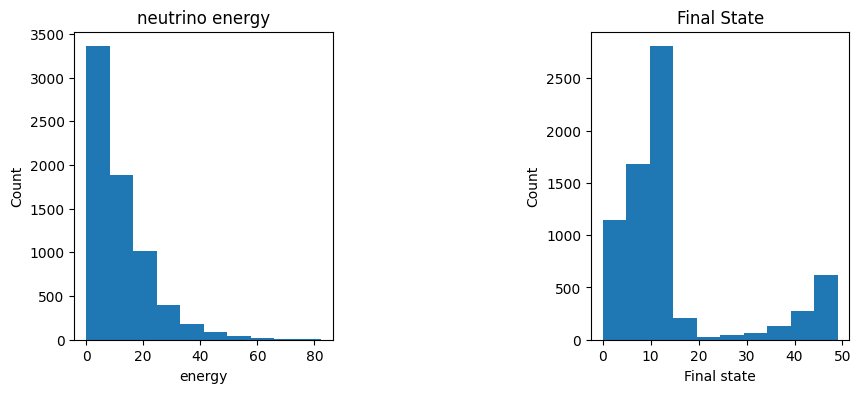

In [ ]:
fs=np.array(df['neutrino']['finalstate'])
nuenergy=np.array(df['neutrino']['nuenergy'])
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(nuenergy)
ax[0].set_title('neutrino energy')
ax[0].set_xlabel('energy')
ax[0].set_ylabel('Count')
plt.subplots_adjust(wspace=1.0)
ax[1].hist(fs)
ax[1].set_title('Final State')
ax[1].set_xlabel('Final state')

ax[1].set_ylabel('Count')


# _Task 1 Binary Classifier_
> Task 1 involves developing a binary event classifier to distinguish between images of neutrino interactions that are νμ charged-current and those that are not. The classifier will be trained on a labeled dataset of images using machine learning techniques.


# CREATE DATASET

*The data has already been downloaded from UCL website (NOvA experiment) and stored in data variable. However only a portion of the data will be used for training purposes, otherwise the computational cost would be really high.*

*Also it is useful to have the "raw" data stored in case later in the notebok we want to access it and no changes has been sone to it.*


In [ ]:
# Start with a single event and add the next 20? neutrinos to it.

#IMAGE(input)
neutrino_events=np.array(data[1]['cvnmap'],dtype='uint8')
#LABEL(target)
neutrino_l=np.array(data[1]['neutrino']['interaction'],dtype='uint8')
print(neutrino_l.shape) #get every event from neutrino x and the label are the interactions for each event (7001 labels for neutrino1)


# Get data from first 20 neutrinos:
for i in tqdm(range(2,20)):#start from neutrino 2
    neutrino_events = np.concatenate((neutrino_events, np.array(data[i]['cvnmap'],dtype='uint8')))
    neutrino_l = np.concatenate((neutrino_l, np.array(data[i]['neutrino']['interaction'],dtype='uint8')))
    
   

(7001, 1)


100%|██████████| 18/18 [00:14<00:00,  1.26it/s]


In [ ]:
print(f'In the data downloaded from UCL website on data we have now {neutrino_events[:,1].shape[0]} events each with a label of the interaction type')


In the data downloaded from UCL website on data we have now 132000 events each with a label of the interaction type


*Different neutrino events*

This plot shows the distribution of different types of neutrino events in the dataset

Muon neutrino events: 116284
Electron neutrino events: 1460
Tau neutrino events: 0
Other events: 14256


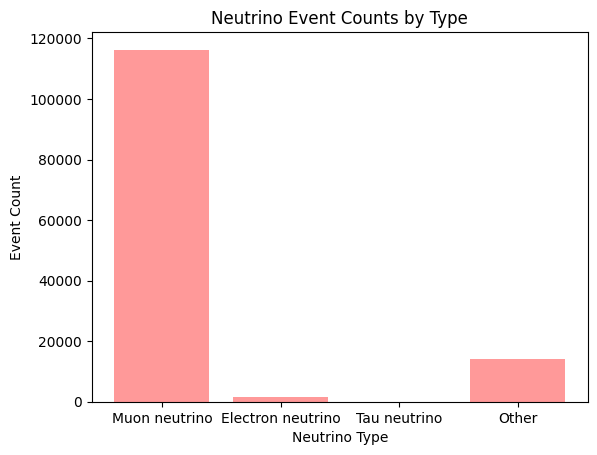

In [ ]:
# Before turning into a binary problem let's find the number of muon, tau, electron and other neutrinos events.
# initialize counters
numu_counter = 0
nue_counter = 0
nutau_counter = 0
other_counter = 0

# loop over each event and count the number of events for each type of neutrino
for i in range(neutrino_l.shape[0]):
    if neutrino_l[i] <= 3: # muon neutrino events
        numu_counter += 1
    elif neutrino_l[i] > 4 and neutrino_l[i] <= 7: # electron neutrino events
        nue_counter += 1
    elif neutrino_l[i] > 7 and neutrino_l[i] <= 11: # tau neutrino events
        nutau_counter += 1
    else: # other events
        other_counter += 1

# print the counts for each type of neutrino
print("Muon neutrino events:", numu_counter)
print("Electron neutrino events:", nue_counter)
print("Tau neutrino events:", nutau_counter)
print("Other events:", other_counter)
# create a dictionary to store the counts for each type of neutrino
neutrino_counts = {'Muon neutrino': numu_counter, 'Electron neutrino': nue_counter, 'Tau neutrino': nutau_counter, 'Other': other_counter}

# create a bar chart to visualize the counts
plt.bar(neutrino_counts.keys(), neutrino_counts.values(), color='#ff9999')

# set chart title and labels
plt.title('Neutrino Event Counts by Type')
plt.xlabel('Neutrino Type')
plt.ylabel('Event Count')

# show the chart

plt.savefig('event_count_t1.png')

*Reshape labels according to FAQ for PHAS0056 Neutrino Event Classification
mini-project.*

*To a boolean for a binary problem.*

In [ ]:
#Reshape neutrino_events to (100,80,2 shape for images)
neutrino_event_input=neutrino_events.reshape((neutrino_events.shape[0],2,100,80)).transpose(0,2,3,1)

#Change labels to binary where 1 means the interaction is (0,1,2 or 3) --> 1 (νμ charged-current event) 
# and any other number ---> 0.
event_labels=np.where(neutrino_l > 3, 0, 1).astype(bool)

print(event_labels) # To use this as out target data it is needed a change from array [[]] to integers/booleans

[[ True]
 [ True]
 [ True]
 ...
 [ True]
 [False]
 [ True]]


*Further analysis of our data*

Study Class distribution since this might arise problems in trianing (biased).

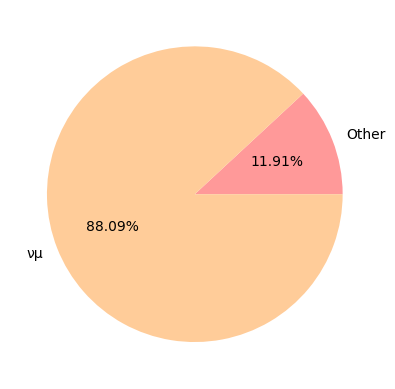

In [ ]:
#count classes
lbl, counts = np.unique(event_labels, return_counts=True)
custom_colors = ['#ff9999','#ffcc99']
r=['Other','νμ'] #labels
plt.pie(counts, labels=r,autopct='%1.2f%%',colors=custom_colors)

plt.savefig('umbalance_bi.png')

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


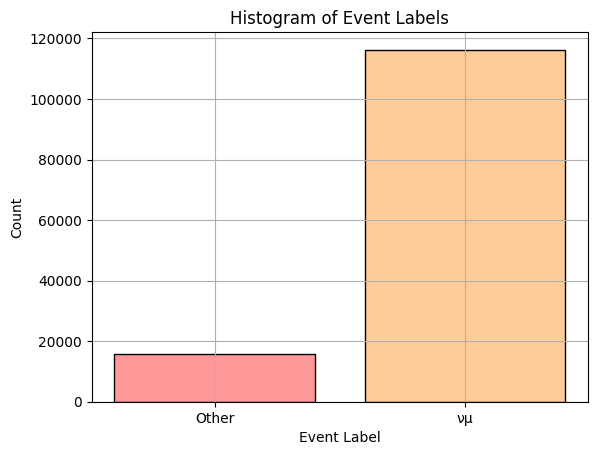

In [ ]:
# Calculate the histogram counts and edges
hist, bins = np.histogram(event_labels, bins=[-0.5, 0.5, 1.5])

# Create the histogram bars
plt.bar([0, 1], hist, edgecolor='black', color=custom_colors)

# Add labels and title
plt.xlabel('Event Label')
plt.ylabel('Count')
plt.title('Histogram of Event Labels')
plt.grid()
# Set the x-axis ticks and labels
plt.xticks([0, 1], ['Other','νμ'])

plt.savefig('umbalance_bi_hist.png')

>> _There is a distribution of classes problem. Current neutrino events are far lass present than the others. This problem needs to be addressed, otherwise the model will be biased._

In [ ]:

def Classes_gen(data, labels):
    '''
    This function takes in a dataset and corresponding labels and generates a dictionary
    where each key is a label value and the corresponding value is a list of data samples
    with that label.

    Args:
    - data: a numpy array of shape (num_samples, ...) representing the dataset
    - labels: a list or numpy array of shape (num_samples,) containing the label value for each sample

    Returns:
    - classes: a dictionary where each key is a label value and the corresponding value is a list
    of data samples with that label
    '''

    classes = {} # initialize an empty dictionary to hold the classes

    # loop through each label and corresponding data sample
    for i, n in enumerate(labels):

        # check if the label is an array
        if type(n) == np.ndarray:
            val = n[0] # take the boolean out of the list
        else:
            val = n

        # check if the label is already a class
        if val in list(classes.keys()):
            classes[val].append(data[i]) # append the data sample to the corresponding class
        else:
            classes[val]=[data[i]] # create a new class with the current label and data sample

    return classes # return the dictionary containing the classes


In [ ]:
def Undersample(data, lbl):
    '''
    This function takes in a dataset and corresponding labels and performs undersampling on the dataset
    to balance the classes. The function generates a new dataset and labels array with an equal number
    of samples for each class.

    Args:
    - data: a numpy array of shape (num_samples, ...) representing the dataset
    - lbl: a list or numpy array of shape (num_samples,) containing the label value for each sample

    Returns:
    - dataset: a numpy array of shape (num_samples, ...) representing the undersampled dataset
    - labels: a numpy array of shape (num_samples, 1) containing the corresponding label value for each
    sample in the undersampled dataset
    '''

    classes = Classes_gen(data, lbl) # generate a dictionary of classes using the Classes_gen function

    # shuffle the samples in each class
    for key, values in list(classes.items()):
        perm=np.random.permutation(len(values))
        classes[key]=np.array(values)[perm]

    # find the minority class
    min_class=np.min([len(classes[i]) for i in list(classes.keys())])

    # generate new dataset and label arrays with equal number of samples for each class
    data_eq = np.array([ i for clas in list(classes.values()) for i in clas[:min_class] ])
    labels_eq = np.array([ [j] for i in list(classes.keys()) for j in [i]*min_class])

    # shuffle the new dataset and label arrays
    perm=np.random.permutation(len(labels_eq))
    dataset=data_eq[perm]
    labels=labels_eq[perm]

    return dataset, labels # return the undersampled dataset and corresponding labels


*Deal with class imbalanced*

*SOLVED!*

In [ ]:
data_eq, labels_eq = Undersample(neutrino_event_input, event_labels)

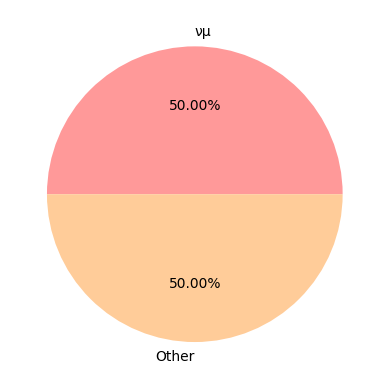

In [ ]:
lbl, counts = np.unique(labels_eq, return_counts=True)
custom_colors = ['#ff9999','#ffcc99']
r=['νμ', 'Other'] #labels
plt.pie(counts, labels=r,autopct='%1.2f%%',colors=custom_colors)

plt.savefig('balance_bi.png')

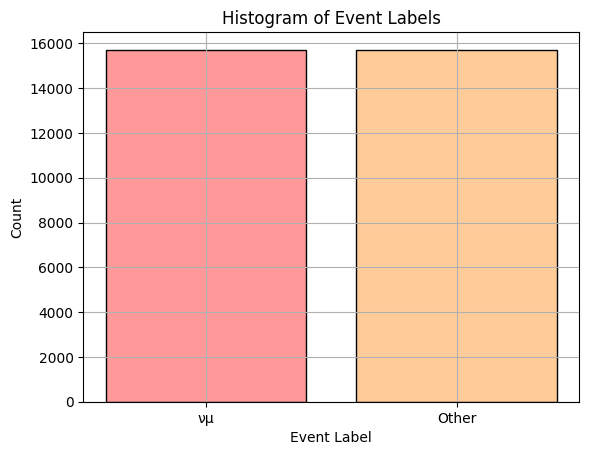

In [ ]:
# Calculate the histogram counts and edges
hist, bins = np.histogram(labels_eq, bins=[-0.5, 0.5, 1.5])

# Create the histogram bars
plt.bar([0, 1], hist, edgecolor='black', color=custom_colors)

# Add labels and title
plt.xlabel('Event Label')
plt.ylabel('Count')
plt.title('Histogram of Event Labels')
plt.grid()
# Set the x-axis ticks and labels
plt.xticks([0, 1], ['νμ', 'Other'])


plt.savefig('balance_bi_hist.png')

*Normalisation*

CONTRAST NORMALIZATION:

This kind of normalization was chosed because is particularly useful when dealing with images that have varying levels of brightness or contrast. By applying contrast normalization to our neutrino images, we can standardize the brightness and contrast of the images, making them more uniform and easier to compare.

Text(0, 0.5, 'z')

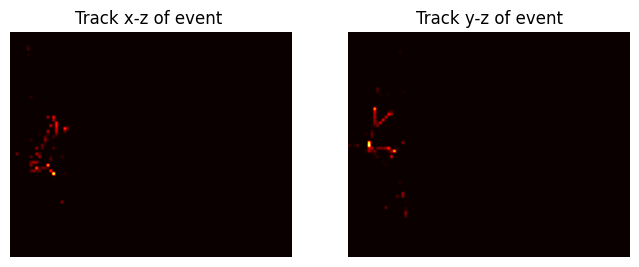

In [ ]:
fig,ax =plt.subplots(1,2,figsize=(8,7))
ax[0].imshow(data_eq[1][:,:,0].T,cmap="hot")
ax[0].axis('off')

ax[1].imshow(data_eq[1][:,:,1].T,cmap="hot")
ax[1].axis('off')

ax[0].set_title(f'Track x-z of event ')
ax[0].set_xlabel('x')

ax[0].set_ylabel('z')
#plt.subplots_adjust(wspace=0.6)
ax[1].set_title(f'Track y-z of event')
ax[1].set_xlabel('y')

ax[1].set_ylabel('z')

In [ ]:
def contrast_normalization(event, event1=None, event2=None):
    if event1 is None and event2 is None:
        # calculate mean and standard deviation for each channel
        # x-z track
        std_intensity_xz = np.std(event[:][:, :, 0])
        mean_intensity_xz = np.mean(event[:][:, :, 0])

        # y-z track
        std_intensity_yz = np.std(event[:][:, :, 1])
        mean_intensity_yz = np.mean(event[:][:, :, 1])

        # normalize xz channel
        dataset_contrast_norm_xz = (event[:][:, :, 0] - mean_intensity_xz) / std_intensity_xz
        event[:][:, :, 0] = dataset_contrast_norm_xz

        # normalize yz channel
        dataset_contrast_norm_yz = (event[:][:, :, 1] - mean_intensity_yz) / std_intensity_yz
        event[:][:, :, 1] = dataset_contrast_norm_yz

        return event
    
    else:
        # calculate mean and standard deviation for each channel
        # x-z track
        std_intensity_xz = np.std(event1)
        mean_intensity_xz = np.mean(event1)

        # y-z track
        std_intensity_yz = np.std(event2)
        mean_intensity_yz = np.mean(event2)

        # normalize xz channel
        dataset_contrast_norm_xz = (event1 - mean_intensity_xz) / std_intensity_xz
        event1 = dataset_contrast_norm_xz

        # normalize yz channel
        dataset_contrast_norm_yz = (event2 - mean_intensity_yz) / std_intensity_yz
        event2 = dataset_contrast_norm_yz

        return event1, event2


In [ ]:
# CONTRAST NORMALIZATION
data_eq = contrast_normalization(data_eq)


*Ensure the transformations and undersampling had no major visual effects on the images*

Text(0, 0.5, 'z')

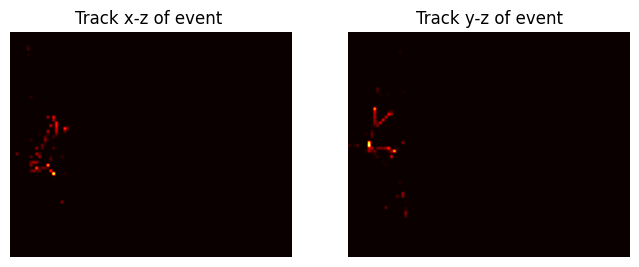

In [ ]:
fig,ax =plt.subplots(1,2,figsize=(8,7))
ax[0].imshow(data_eq[1][:,:,0].T,cmap="hot")
ax[0].axis('off')

ax[1].imshow(data_eq[1][:,:,1].T,cmap="hot")
ax[1].axis('off')

ax[0].set_title(f'Track x-z of event ')
ax[0].set_xlabel('x')

ax[0].set_ylabel('z')
#plt.subplots_adjust(wspace=0.6)
ax[1].set_title(f'Track y-z of event')
ax[1].set_xlabel('y')

ax[1].set_ylabel('z')

# Split data into train/test

In [ ]:
data_train, data_test, lbl_train, lbl_test = train_test_split(data_eq,labels_eq, test_size=0.2, random_state=42)


# MODEL ARCHITECTURE
### Inception module

In [ ]:
# Setting up Inception architecture
def inception_module(layer_in, k1, k3, k5, kp):
    # 1x1 conv
    conv1 = Conv2D(k1, (1,1), padding='same', activation='relu')(layer_in)
    
    # 3x3 conv
    conv3 = Conv2D(k3, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(k3, (3,3), padding='same', activation='relu')(conv3)
    
    # 5x5 conv
    conv5 = Conv2D(k5, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(k5, (5,5), padding='same', activation='relu')(conv5)
    
    # Pooling
    convp = MaxPooling2D((3,3), strides = 1, padding='same')(layer_in)
    convp = Conv2D(kp, (1,1), padding='same', activation='relu')(convp)
 
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, convp], axis=-1)

    return layer_out

####################################################################
# Input branch
inputs = Input(shape=(100, 80, 2))

# First, Seperable convolutional layer of 32, 7x7 kernals; Pooling 2x2 and Spatial dropout for overfitting
conv1 = keras.layers.SeparableConv2D(32, 7, activation='relu', input_shape=(100,80,2))(inputs)
pool1 = keras.layers.MaxPooling2D((2, 2), strides = 2)(conv1)
drop1 = keras.layers.SpatialDropout2D(0.4)(pool1)

# Second convolutional layer of 32, 3x3 kernals; Pooling 2x2  and dropout for overfitting
conv2 = keras.layers.Conv2D(64, 3, activation='relu', input_shape=(100,80,2))(drop1)
pool2 = keras.layers.MaxPooling2D((2, 2), strides = 2)(conv2)
drop2 = keras.layers.SpatialDropout2D(0.4)(pool2)

# Inception layer
incp1 = inception_module(drop2,64, 96, 16,32)
incp2 = inception_module(incp1,64, 96, 16,32)


# Third convolutional layer of 64, 3x3 kernals 
conv3 = keras.layers.Conv2D(64, 3, activation='relu')(incp2)
drop3 = keras.layers.Dropout(0.7)(conv3)

# Fully connected Neural Network
flatn = keras.layers.Flatten()(drop3)
dens1 = keras.layers.Dense(128, activation='relu')(flatn)
drop4 = keras.layers.Dropout(0.8)(dens1)
dens2 = keras.layers.Dense(64, activation='relu')(drop4)
# We have a dropout layer to prevent overfitting
drop = keras.layers.Dropout(0.8)(dens2)

# Create output layer
output_layer = keras.layers.Dense(1, activation = 'sigmoid')(drop)

# Create model
incp_model = Model(inputs= inputs, outputs=output_layer)

# Compile the network with binary crossentropy loss and adam optimiser with learning rate of 1.0
incp_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                    loss      = tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                    metrics   = [keras.metrics.BinaryAccuracy()])

incp_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 80, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 94, 74, 32)  194         ['input_2[0][0]']                
 onv2D)                                                                                           
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 47, 37, 32)  0           ['separable_conv2d_1[0][0]']     
                                                                                              

In [ ]:


history_t1 = incp_model.fit( data_train, lbl_train, 
                     validation_split=0.33, batch_size =100, epochs=35, verbose = 2)


Epoch 1/35
169/169 - 63s - loss: 0.6743 - binary_accuracy: 0.5957 - val_loss: 0.6286 - val_binary_accuracy: 0.6835 - 63s/epoch - 373ms/step
Epoch 2/35
169/169 - 57s - loss: 0.6188 - binary_accuracy: 0.6517 - val_loss: 0.5841 - val_binary_accuracy: 0.7084 - 57s/epoch - 340ms/step
Epoch 3/35
169/169 - 57s - loss: 0.5754 - binary_accuracy: 0.7039 - val_loss: 0.5446 - val_binary_accuracy: 0.7260 - 57s/epoch - 337ms/step
Epoch 4/35
169/169 - 58s - loss: 0.5461 - binary_accuracy: 0.7273 - val_loss: 0.5349 - val_binary_accuracy: 0.7267 - 58s/epoch - 342ms/step
Epoch 5/35
169/169 - 59s - loss: 0.5251 - binary_accuracy: 0.7427 - val_loss: 0.5102 - val_binary_accuracy: 0.7454 - 59s/epoch - 349ms/step
Epoch 6/35
169/169 - 57s - loss: 0.5113 - binary_accuracy: 0.7606 - val_loss: 0.4851 - val_binary_accuracy: 0.7696 - 57s/epoch - 338ms/step
Epoch 7/35
169/169 - 57s - loss: 0.4988 - binary_accuracy: 0.7698 - val_loss: 0.5076 - val_binary_accuracy: 0.7479 - 57s/epoch - 340ms/step
Epoch 8/35
169/169 -

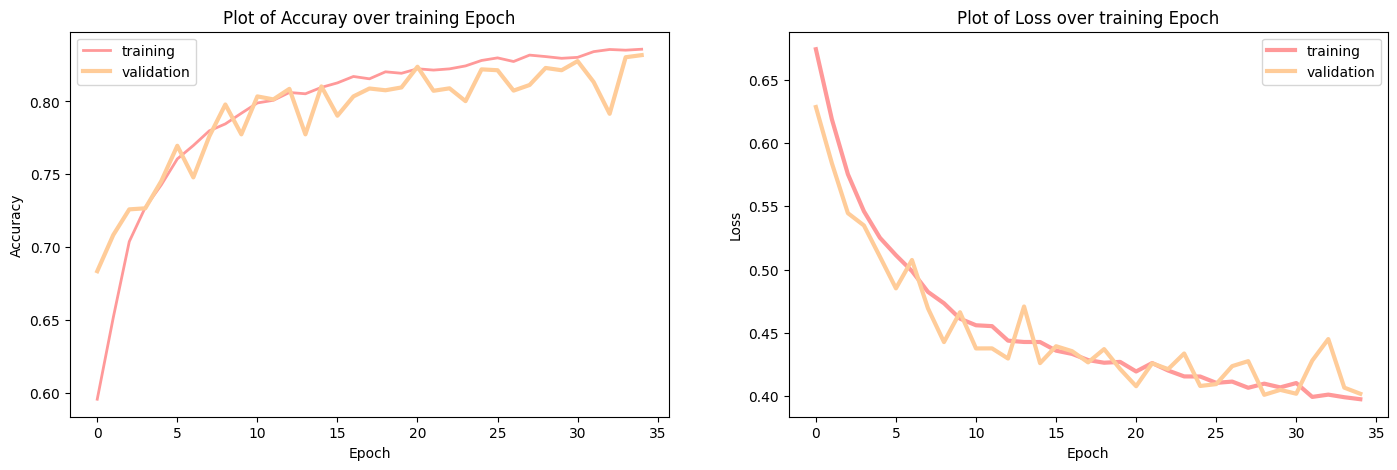

786/786 [==============================] - 20s 26ms/step


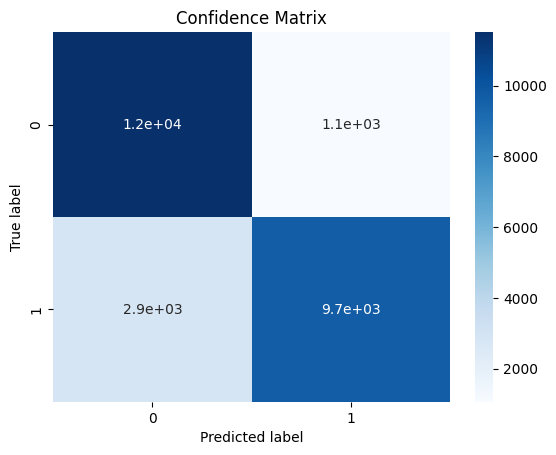

In [ ]:
train_test_visuals(history_t1, incp_model, data_train, lbl_train, split_data=False)
plt.savefig('train_t1')

**SAVE MODEL**

In [ ]:
incp_model.save('/content/drive/MyDrive/neutrino_ML/inception_model')

**LOAD SAVED MODEL**

In [ ]:
# RUN THIS CELL IF MODEL HAS BEING ALREADY SAVE IN DRIVE.

os.chdir('/content/drive/MyDrive/neutrino_ML/')
incp_model = tf.keras.models.load_model('inception_model')

In [ ]:
# Test accuracy of trained network
test_loss, test_acc = incp_model.evaluate(data_test, lbl_test, verbose=0)

print(f'The accuracy of the network on balanced data is {test_acc*100:.2f}%')

The accuracy of the network on balanced data is 83.44%


# Now on electron neutrinos (NOT NECESSARY)

In [ ]:
# ELECTRON NEUTRINO LOADER
# Start with a single event and add the next 20? neutrinos to it.

#IMAGE(input)
E_neutrino_event=np.array(data[1]['cvnmap'],dtype='uint8')
#LABEL(target)
E_neutrino_l=np.array(data[1]['neutrino']['interaction'],dtype='uint8')
print(E_neutrino_l.shape) #get every event from neutrino x and the label are the interactions for each event (7001 labels for neutrino1)


# Get data from first 35 neutrinos:
for i in tqdm(range(2,35)):#start from neutrino 2
    E_neutrino_event = np.concatenate((E_neutrino_event, np.array(data[i]['cvnmap'],dtype='uint8')))
    E_neutrino_l = np.concatenate((E_neutrino_l, np.array(data[i]['neutrino']['interaction'],dtype='uint8')))
    

(7001, 1)


100%|██████████| 33/33 [00:36<00:00,  1.10s/it]


In [ ]:
# BINARY
#Reshape neutrino_events to (100,80,2 shape for images)
E_neutrino_event_input=E_neutrino_event.reshape((E_neutrino_event.shape[0],2,100,80)).transpose(0,2,3,1)

#Change labels to binary where 1 means the interaction is (0,1,2 or 3) --> 1 (νμ charged-current event) 
# and any other number ---> 0.
E_event_labels=np.where((E_neutrino_l > 3) & (E_neutrino_l <= 7), 1, 0).astype(bool)


print(E_event_labels) # To use this as out target data it is needed a change from array [[]] to integers/booleans


[[False]
 [False]
 [False]
 ...
 [False]
 [False]
 [False]]


In [ ]:
E_data_eq, E_labels_eq = Undersample(E_neutrino_event_input, E_event_labels)

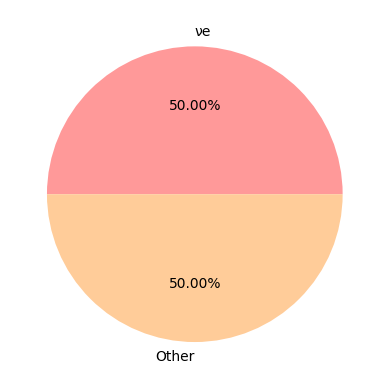

In [ ]:
E_lbl, E_counts = np.unique(E_labels_eq, return_counts=True)
custom_colors = ['#ff9999','#ffcc99']
r=['νe', 'Other'] #labels
plt.pie(E_counts, labels=r,autopct='%1.2f%%',colors=custom_colors)
plt.show()

In [ ]:
# NORMALISATION
# CONTRAST NORMALIZATION
#x-z track
e_std_intensity_xz = np.std(E_data_eq[:][:, :, 0])
e_mean_intensity_xz = np.mean(E_data_eq[:][:, :, 0])

#y-z track
e_std_intensity_yz = np.std(E_data_eq[:][:, :, 1])
e_mean_intensity_yz = np.mean(E_data_eq[:][:, :, 1])

# Normalize each image channel of the xz track dataset by subtracting the mean and dividing by the standard deviation
E_dataset_contrast_norm_xz = np.zeros(E_data_eq[:][:, :, 0].shape)
E_dataset_contrast_norm_xz = (E_data_eq[:][:, :, 0] - e_mean_intensity_xz) / e_std_intensity_xz
E_data_eq[:][:, :, 0] = E_dataset_contrast_norm_xz

# Normalize each image channel of the yz track dataset by subtracting the mean and dividing by the standard deviationdataset_contrast_norm_yz = np.zeros(neutrino_event_input[:][:, :, 1].shape)
E_dataset_contrast_norm_yz = (E_data_eq[:][:, :, 1] - e_mean_intensity_yz) / e_std_intensity_yz
E_data_eq[:][:, :, 1] = E_dataset_contrast_norm_yz

# SPLIT
E_data_train, E_data_test, E_lbl_train, E_lbl_test = train_test_split(E_data_eq,E_labels_eq, test_size=0.2, random_state=42)


In [ ]:
# history = model.fit((train_event_inputs[:,:,:,0], train_event_inputs[:,:,:,1]), train_event_labels, 
#                     validation_split=0.33, batch_size =100, epochs=15, verbose = 2)
# Create model
e_model = Model(inputs= inputs, outputs=output_layer)

# Compile the network with binary crossentropy loss and adam optimiser with learning rate of 1.0
e_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                    loss      = tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                    metrics   = [keras.metrics.BinaryAccuracy()])

history = model.fit( E_data_train, E_lbl_train, 
                     validation_split=0.33, batch_size =100, epochs=25, verbose = 2)


Epoch 1/25
31/31 - 155s - loss: 0.8120 - binary_accuracy: 0.5274 - val_loss: 0.6896 - val_binary_accuracy: 0.5924 - 155s/epoch - 5s/step
Epoch 2/25
31/31 - 167s - loss: 0.6926 - binary_accuracy: 0.5284 - val_loss: 0.6886 - val_binary_accuracy: 0.5721 - 167s/epoch - 5s/step
Epoch 3/25
31/31 - 151s - loss: 0.6743 - binary_accuracy: 0.5562 - val_loss: 0.6634 - val_binary_accuracy: 0.6481 - 151s/epoch - 5s/step
Epoch 4/25
31/31 - 152s - loss: 0.6586 - binary_accuracy: 0.5836 - val_loss: 0.6495 - val_binary_accuracy: 0.6501 - 152s/epoch - 5s/step
Epoch 5/25
31/31 - 148s - loss: 0.6531 - binary_accuracy: 0.5917 - val_loss: 0.6579 - val_binary_accuracy: 0.5976 - 148s/epoch - 5s/step
Epoch 6/25
31/31 - 152s - loss: 0.6345 - binary_accuracy: 0.6301 - val_loss: 0.6492 - val_binary_accuracy: 0.6409 - 152s/epoch - 5s/step
Epoch 7/25
31/31 - 147s - loss: 0.6324 - binary_accuracy: 0.6414 - val_loss: 0.6486 - val_binary_accuracy: 0.6166 - 147s/epoch - 5s/step
Epoch 8/25
31/31 - 149s - loss: 0.6161 - 

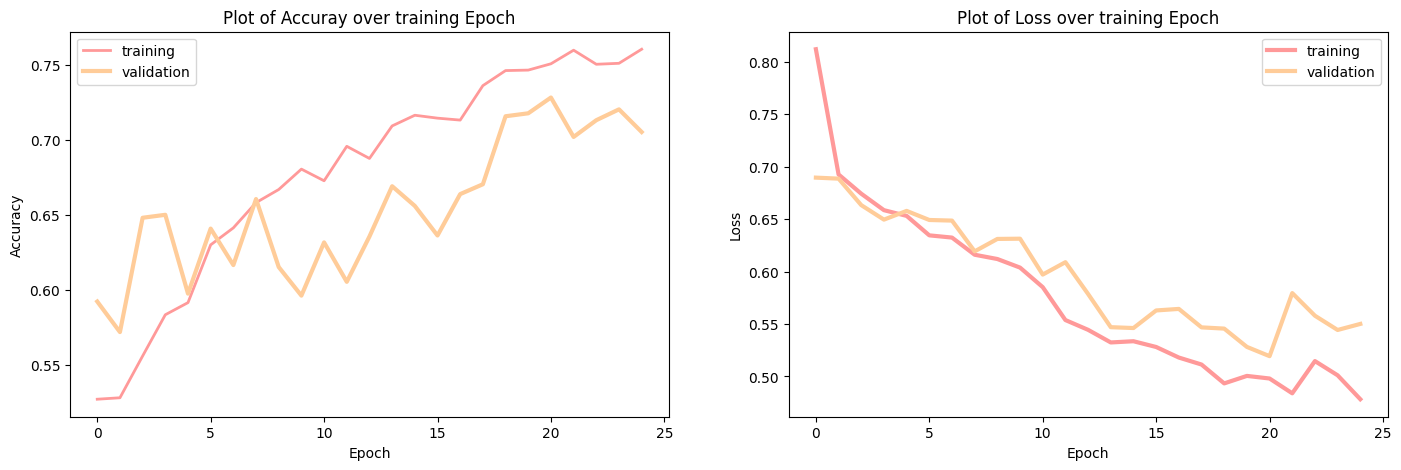

37/37 [==============================] - 13s 346ms/step


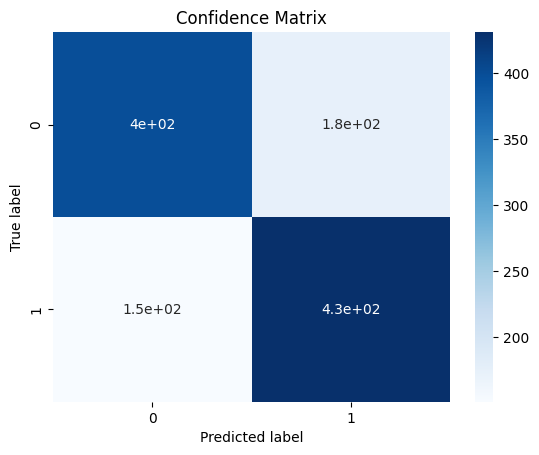

In [ ]:
train_test_visuals(history, e_model, E_data_test,E_lbl_test, split_data=False)

**LOAD AND SAVE MODEL**

In [ ]:
e_model.save('/content/drive/MyDrive/neutrino_ML/inception_model_electron_neutrino')

In [ ]:
os.chdir('/content/drive/MyDrive/neutrino_ML/')
E_model_saved = tf.keras.models.load_model('inception_model_electron_neutrino')

In [ ]:
# Test accuracy of trained network
E_test_loss, E_test_acc = E_model_saved.evaluate(E_data_test, E_lbl_test, verbose=0)

print(f'The accuracy of the network on balanced data is {E_test_acc*100:.2f}%')

The accuracy of the network on balanced data is 71.97%


# TASK 2
*Test your machine learning classifier and investigate how the efficiency of the classifier depends on the meta data variables shown above*

*Make predictions on dataset testing*

In [ ]:
# Model.predict produce array of predictions (percentage of certainties) 
y_score = incp_model.predict(data_test, batch_size = 100)
# True values are the labels
y_true  = lbl_test



63/63 [==============================] - 5s 71ms/step


*Histogram predictions*

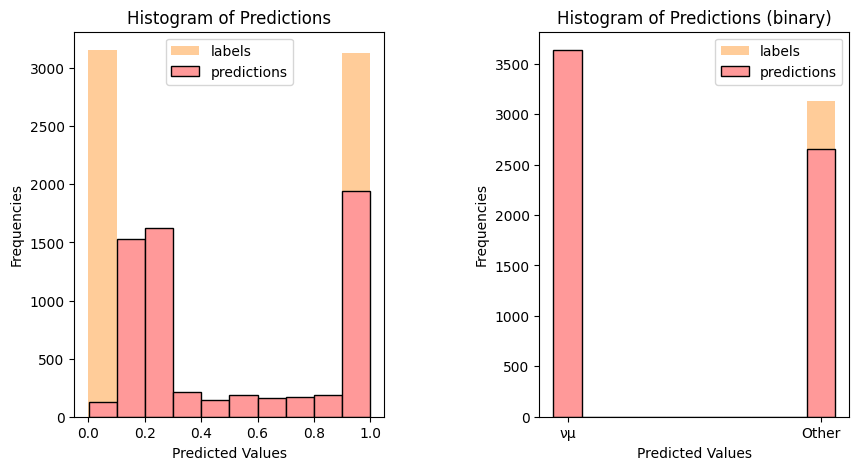

In [ ]:
# Create class dictionary
test_classes = Classes_gen(data_test, lbl_test)

# Plotting Histogram of predictions
fig,ax=plt.subplots(1,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.5)


# Setting axis and labels
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Frequencies')
ax[0].set_title('Histogram of Predictions')
# Histogram
ax[0].hist(lbl_test.astype(int), label = 'labels',color='#ffcc99')
ax[0].hist(y_score, label = 'predictions', color='#ff9999', ec='black')
ax[0].legend()

######################################################

ax[1].set_xlabel('Predicted Values')
ax[1].set_ylabel('Frequencies')
ax[1].set_title('Histogram of Predictions (binary)')
lbl_test2 = np.where(y_score>0.5,1,0)
# Histogram binary when pred > 0.5 ---> 1, otherwise 0.
ax[1].hist(lbl_test.astype(int), label = 'labels', color='#ffcc99')
ax[1].hist(lbl_test2, label = 'predictions', color='#ff9999', ec='black')
ax[1].set_xticks([0.05, 0.95], ['νμ', 'Other'])
ax[1].legend()

plt.savefig('hist_pred')

In [ ]:
muon_n_test = np.count_nonzero(lbl_test2 == 0)
other_test = np.count_nonzero(lbl_test2 == 1)
# Real values
muon_n_real = np.count_nonzero(lbl_test == 0)
other_real = np.count_nonzero(lbl_test == 1)
print(f'Model fails to predict {abs(-muon_n_test+muon_n_real)/(muon_n_real)*100:.2f}% of total mu-neutrinos  and {abs(-other_test+other_real)/(other_real)*100:.2f}% of other interactions ')


Model fails to predict 15.25% of total mu-neutrinos  and 15.36% of other interactions 


> *The error of the model on test data is around (8-13)%*


*ROC curve & Precision Recall curve*

63/63 [==============================] - 5s 73ms/step


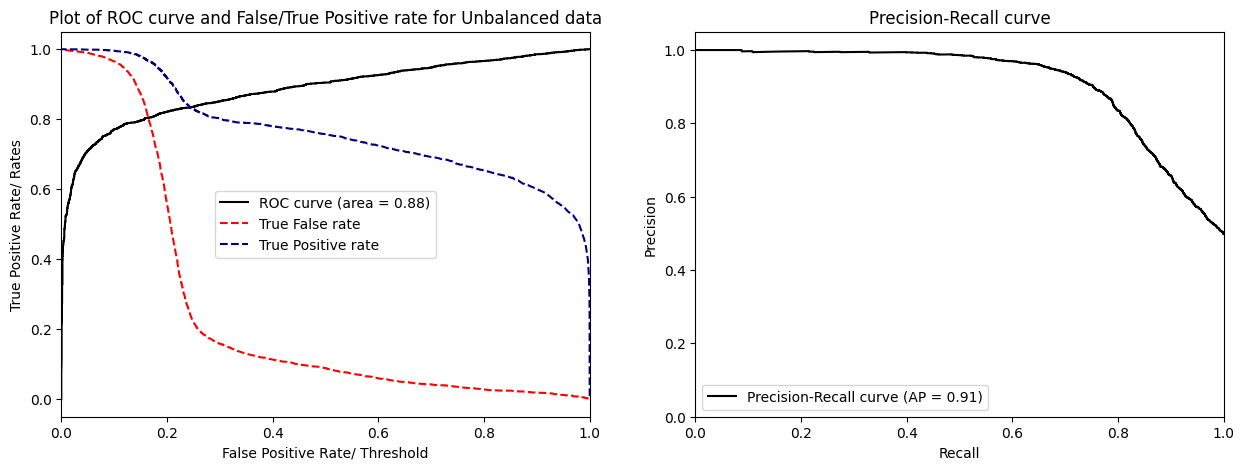

<Figure size 640x480 with 0 Axes>

In [ ]:

model_metrics(incp_model,data_test,lbl_test,100)
plt.savefig('ROC_PRC')

*ERROR COUNT*

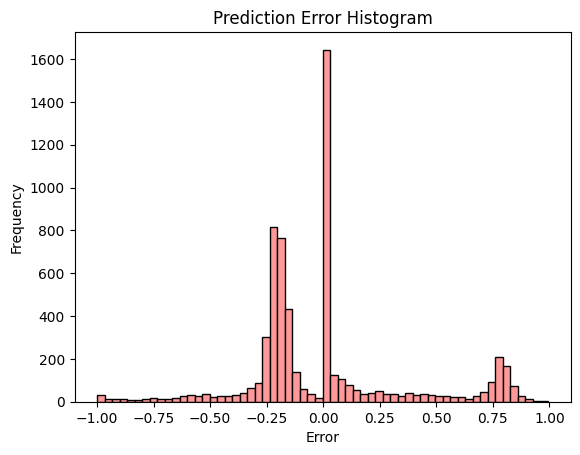

In [ ]:
# ERROR VARIANCE
int_array = y_true.astype(int)
variance = int_array-y_score
plt.hist(variance, bins=60, color='#ff9999',ec='k')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Histogram')
plt.savefig('error_mag_count')

▶ **The most common error difference is from -0.3 to 0.1**

📶 Let's check how the classifier performs in the different interactions and energies.


# ACCURACY OVER DIFFERENT INTERACTION TYPES (QE,DIS,RES...).

In [ ]:
def Dictionary(input_dic,input_array, n_data, **bin_kwargs):
  '''
  Args:
  input_dic     ---------> Dictionary with differents metadata
  input_array   ---------> input (metadata) that will be store in the corresponding level on the dictionary
  n_data        ---------> Number of item added
  **bin_kwargs  ---------> Keyword arguements used sort energy in binned strata

  Returns:
  Input_dictionary ---------> Updated dictionary holding sorted data
  '''
  # for each metadata key in each file
  for i in data[n_data]['neutrino'].keys():
    # meta-data key is in dictionary
    if i in input_dic:
      None
    else:
      input_dic[i] = {}

    for j in range(len(input_array)):
      # Get item from dictionary
      k = data[n_data]['neutrino'][i][j][0]

      if k in input_dic[i]:
        input_dic[i][k].append(input_array[j])
      else:
        input_dic[i][k] = [input_array[j]]

  #####################################################
  #             ENERGY IN DICTIONARY                  #
  #####################################################

  # Ensure energy key does exist and create it if not
  if 'energy' in input_dic:
    None
  else:
    input_dic['energy'] = {}

  # Add energy to each event using the lepton and neutrino energy
  for i in range(len(input_array)):

    # Energy calculation (Incoming Neutrino energy + Outgoing Lepton energy) (GeV)
    energy = data[n_data]['neutrino']['nuenergy'][i][0] + data[n_data]['neutrino']['lepenergy'][i][0]

    # Add energy to energy key in dictionary
    if energy in input_dic['energy']:
      input_dic['energy'][energy].append(input_array[i])

    else:
      input_dic['energy'][energy] = [input_array[i]]

    
  # If we have bin_kwargs, adds to dictionary
  for keys, values in bin_kwargs.items():
        
      # Extract data label
      bin_data_label = str(keys)+str(values)
        
      # Adds label to dictionary
      if bin_data_label in input_dic:
          None
      else:
          input_dic[bin_data_label] = {} 
            
      # For the data in the array adds to corresponding key
      for i in range(len(input_array)):
           # Uses kwarg value to round data into stara bin, with condition for if it is energy
          if keys == 'energy':
               k_energy= data[n_data]['neutrino']['nuenergy'][i][0] + data[n_data]['neutrino']['lepenergy'][i][0]
               k = values*round(k_energy/values)
          else:
              k = values*round(data[n_data]['neutrino'][keys][i][0]/values)
            
          # Adds data to corresponding dictionary location
          if k in input_dic[bin_data_label]:
              input_dic[bin_data_label][k].append(input_array[i])

          else: 
              input_dic[bin_data_label][k] = [input_array[i]]

  return input_dic

In [ ]:
print(f" Groups of 5 since the lenght of lepenergy can be divided in {len(data[7]['neutrino']['lepenergy'])/5} groups")

 Groups of 5 since the lenght of lepenergy can be divided in 1389.0 groups


([<matplotlib.axis.XTick at 0x7f101c39ed30>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(25, 0, '25'),
  Text(30, 0, '30'),
  Text(35, 0, '35'),
  Text(40, 0, '40'),
  Text(45, 0, '45'),
  Text(50, 0, '50'),
  Text(55, 0, '55')])

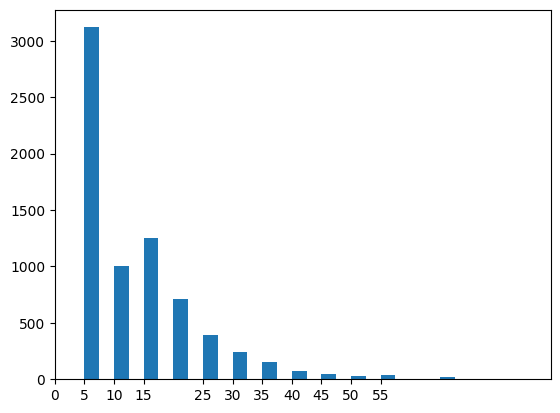

In [ ]:
def scale_number(num, increment=5):
    num = int(num)  # convert num to integer
    thresholds = [increment * i for i in range(1, (num // increment) + 2)]
    for threshold in thresholds:
        if num <= threshold:
            return threshold
interactions=[]
for i in range(1,30):
  scaled_data22 = [scale_number(num, increment=5) for num in data[i]['neutrino']['nuenergy']]
  interactions.append(scaled_data22)
plt.hist(scaled_data22,bins=30)
plt.xticks([0,5,10,15,25,30,35,40,45,50,55])

In [ ]:
# Initialise dictionaries
event_labels_dic, event_scores_dic = {},{}
event_labels_dic_eq, event_scores_dic_eq = {},{} 
# Loops through all data sets
for i in tqdm(range(1,30)):
    # Produce images to test on model
    event        = np.array(data[i]['cvnmap'], dtype='uint8')    
    event_inputs = event.reshape(( event.shape[0],2,100,80 )).transpose(0,2,3,1)
    
    # Produce corresponding labels
    event_l      = np.array(data[i]['neutrino']['interaction'],dtype='uint8')
    event_n_energies  = np.array(data[i]['neutrino']['nuenergy'],dtype='uint8')
    #event_interactions = np.where(np.array(event_l) >= 3, 3, event_l)
    event_labels = np.where( event_l > 3, 0, 1).astype(bool)
    # Make predictions using trained model
    event_scores = incp_model.predict(event_inputs, batch_size = 200)
    event_scores_eq , event_labels_eq = Undersample(event_scores, event_labels)

      
    # Add to labels and scores dictionary, using kwargs of the function to add energies in bins of 5eV
    event_labels_dic = Dictionary(event_labels_dic, event_labels, i, nuenergy = 5, lepenergy = 5, energy = 5)
    event_scores_dic = Dictionary(event_scores_dic, event_scores, i, nuenergy = 5, lepenergy = 5, energy = 5)
    
    # Add to equalised labels and scores dictionary, using kwargs of the function to add energies in bins of 5eV
    event_labels_dic_eq = Dictionary(event_labels_dic_eq, event_labels_eq, i, nuenergy = 5, lepenergy = 5, energy = 5)
    event_scores_dic_eq = Dictionary(event_scores_dic_eq, event_scores_eq, i, nuenergy = 5, lepenergy = 5, energy = 5) 




  0%|          | 0/29 [00:00<?, ?it/s]

36/36 [==============================] - 5s 147ms/step


  3%|▎         | 1/29 [01:20<37:33, 80.49s/it]

35/35 [==============================] - 5s 145ms/step


  7%|▋         | 2/29 [02:40<35:58, 79.96s/it]

36/36 [==============================] - 5s 145ms/step


 10%|█         | 3/29 [04:02<35:11, 81.21s/it]

35/35 [==============================] - 5s 144ms/step


 14%|█▍        | 4/29 [05:23<33:41, 80.85s/it]

34/34 [==============================] - 5s 145ms/step


 17%|█▋        | 5/29 [06:42<32:08, 80.36s/it]

35/35 [==============================] - 5s 144ms/step


 21%|██        | 6/29 [08:04<30:59, 80.85s/it]

35/35 [==============================] - 5s 148ms/step


 24%|██▍       | 7/29 [09:26<29:46, 81.22s/it]

34/34 [==============================] - 5s 148ms/step


 28%|██▊       | 8/29 [10:45<28:14, 80.71s/it]

35/35 [==============================] - 5s 152ms/step


 31%|███       | 9/29 [12:06<26:53, 80.66s/it]

35/35 [==============================] - 5s 151ms/step


 34%|███▍      | 10/29 [13:27<25:32, 80.63s/it]

35/35 [==============================] - 5s 147ms/step


 38%|███▊      | 11/29 [14:47<24:08, 80.49s/it]

35/35 [==============================] - 5s 152ms/step


 41%|████▏     | 12/29 [16:08<22:54, 80.85s/it]

36/36 [==============================] - 5s 145ms/step


 45%|████▍     | 13/29 [17:33<21:51, 81.94s/it]

35/35 [==============================] - 5s 149ms/step


 48%|████▊     | 14/29 [18:55<20:28, 81.89s/it]

35/35 [==============================] - 5s 145ms/step


 52%|█████▏    | 15/29 [20:17<19:08, 82.02s/it]

37/37 [==============================] - 5s 144ms/step


 55%|█████▌    | 16/29 [21:42<17:57, 82.92s/it]

35/35 [==============================] - 5s 148ms/step


 59%|█████▊    | 17/29 [23:02<16:24, 82.03s/it]

36/36 [==============================] - 5s 146ms/step


 62%|██████▏   | 18/29 [24:22<14:57, 81.57s/it]

35/35 [==============================] - 5s 145ms/step


 66%|██████▌   | 19/29 [25:44<13:35, 81.57s/it]

35/35 [==============================] - 5s 144ms/step


 69%|██████▉   | 20/29 [27:04<12:09, 81.03s/it]

35/35 [==============================] - 5s 146ms/step


 72%|███████▏  | 21/29 [28:24<10:47, 80.89s/it]

35/35 [==============================] - 5s 142ms/step


 76%|███████▌  | 22/29 [29:44<09:24, 80.66s/it]

36/36 [==============================] - 5s 148ms/step


 79%|███████▉  | 23/29 [31:10<08:12, 82.14s/it]

35/35 [==============================] - 5s 145ms/step


 83%|████████▎ | 24/29 [32:31<06:48, 81.77s/it]

35/35 [==============================] - 5s 144ms/step


 86%|████████▌ | 25/29 [33:51<05:24, 81.24s/it]

35/35 [==============================] - 5s 149ms/step


 90%|████████▉ | 26/29 [35:14<04:05, 81.76s/it]

35/35 [==============================] - 5s 152ms/step


 93%|█████████▎| 27/29 [36:35<02:42, 81.50s/it]

35/35 [==============================] - 5s 144ms/step


 97%|█████████▋| 28/29 [37:54<01:20, 80.85s/it]

36/36 [==============================] - 5s 144ms/step


100%|██████████| 29/29 [39:19<00:00, 81.37s/it]


In [ ]:
# Ensure all interaction types 
for i in range(17):
    if i in event_labels_dic['interaction']:
        None
    else:
        event_labels_dic['interaction'][i] = []
        event_scores_dic['interaction'][i] = [] 
  

In [ ]:
def Interaction_acc(labels_dic,scores_dic, thres, int_type):
    ''' Calculate accuracy interaction type.
    
    Args:
    Labels_dic - Dictionary containing all labels in meta data strata
    Scores_dic - Dictionary containing all scores in meta data strata
    thres      - Threshold from which scores are turned assigned 0/1
    int_type   - Interaction type, 0: QE, 1: DIS, 2:Res, 4:Others
    
    Return:
    Accuracy- Accuracy of Interaction type
    '''
    
    # List comprehension to extract data from dictionary for thee interaction type given
    #Labels    = np.array( [ value for i in range(3) for value in Labels_dic['interaction'][int_type + 4*i]] )
    lbls = []
    for i in range(3):            
        for value in labels_dic['interaction'][int_type + 4*i]: # take multiples, i.e, (0)0,4,8 or (1)1,5,9
            lbls.append(value)
    lbls = np.array(lbls)
    scores = []
    for i in range(3):
        for value in scores_dic['interaction'][int_type + 4*i]:
            scores.append(value)
    scores = np.array(scores)
    

    
    #Predicions convergence and accuracy for each
    pred = np.where( scores < thres, 0, 1).astype(bool)# if score is < 0.5 ---> Round to 1
    acc   = metrics.accuracy_score(lbls, pred, normalize=True)
    
    return acc

In [ ]:
def get_event_interactions(event_l):
    event_interactions = np.zeros(len(event_l), dtype=int)
    for i in range(len(event_l)):
        if event_l[i] in [0, 4, 8]:
            event_interactions[i] = 0
        elif event_l[i] in [1, 5, 9]:
            event_interactions[i] = 1
        elif event_l[i] in [2, 6, 10]:
            event_interactions[i] = 2
        else:
            event_interactions[i] = 3
    return event_interactions

event_interactions = get_event_interactions(event_l)

Text(0, 0.5, 'Count')

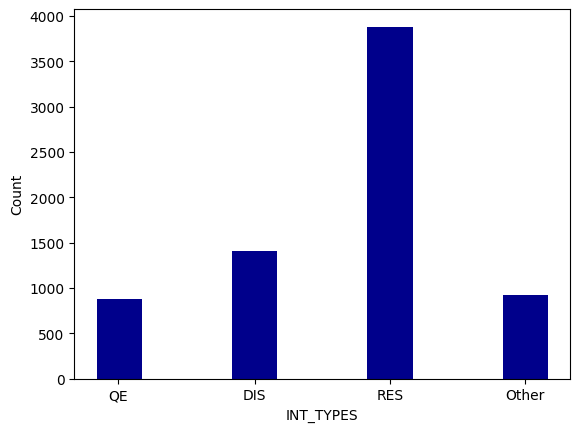

In [ ]:
plt.hist(event_interactions,color='darkblue') #different interactions 

plt.xticks([0.14,1.05,1.95,2.85],['QE', 'DIS', 'RES', 'Other'])
plt.xlabel('INT_TYPES')
plt.ylabel('Count')

In [ ]:

# Set threshold discussed above
thres = 0.5

# Calculate accuracy for each interaction type
QE_acc     = Interaction_acc(event_labels_dic, event_scores_dic, thres, 0)
Res_acc    = Interaction_acc(event_labels_dic, event_scores_dic, thres, 1)
DIS_acc    = Interaction_acc(event_labels_dic, event_scores_dic, thres, 2)
Other_acc  = Interaction_acc(event_labels_dic, event_scores_dic, thres, 3)

# Store Accuracys
Type_keys = np.array(['QE_acc', 'DIS_acc', 'Res_acc', 'Other_acc'])
Type_acc  = np.array([QE_acc, DIS_acc, Res_acc, Other_acc])

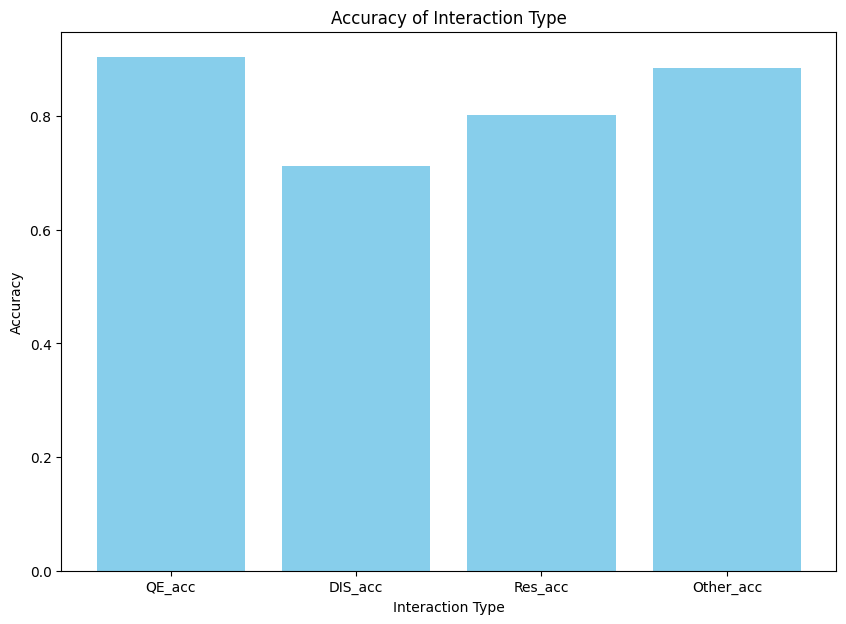

In [ ]:
# Plot of interaction types accuracy
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.bar(Type_keys, Type_acc, color='skyblue')
ax.set_title('Accuracy of Interaction Type')
ax.set_xlabel('Interaction Type')
ax.set_ylabel('Accuracy')

plt.show()

*As it can be seen there is a considerable difference in between DIS events and QE events. However after some inspection it can be infer that there there is a class imbalanced that is affecting the performance (even though the model was trained in a balanced data).*

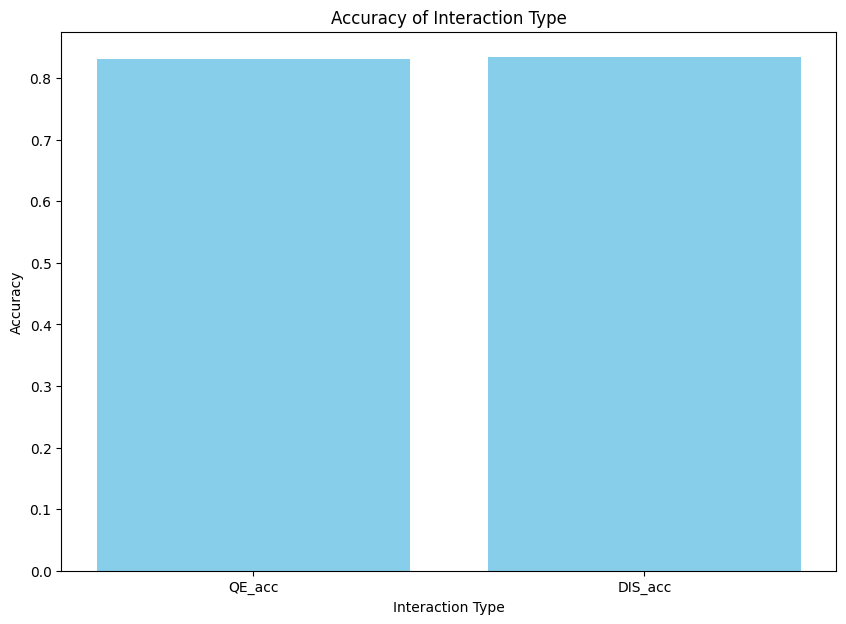

In [ ]:
for i in range(17):
    if i in event_labels_dic_eq['interaction']:
        None
    else:
        event_labels_dic_eq['interaction'][i] = []
        event_scores_dic_eq['interaction'][i] = [] 


# Calculate accuracy for each interaction type
QE_acc_eq     = Interaction_acc(event_labels_dic_eq, event_scores_dic_eq, thres, 0)
DIS_acc_eq   = Interaction_acc(event_labels_dic_eq, event_scores_dic_eq, thres, 2)


# Store Accuracys
Type_keys_eq = np.array(['QE_acc', 'DIS_acc'])
Type_acc_eq  = np.array([QE_acc_eq, DIS_acc_eq])

# Plot of interaction types accuracy
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.bar(Type_keys_eq, Type_acc_eq, color='skyblue')
ax.set_title('Accuracy of Interaction Type')
ax.set_xlabel('Interaction Type')
ax.set_ylabel('Accuracy')

plt.show()

*After addresign the issue described above, it can be concluded that the performance (accuracy in this case) of the classifier works accurately on all the interaction types.*

# PERFORMANCE OVER DIFFERENT ENERGIES


In [ ]:
def meta_data_acc(meta_data, Labels_dic, Scores_dic, thres):
    ''' Function to calculate accuracy over the sub strata of given meta data type.
    
    Inputs:
    Meta_data  - String of meta data; Accuracy calculated for over substrata of that meta data
    Labels_dic - Dictionary contain Labels in meta data strata
    Scores_dic - Dictionary contain Scores in meta data strata
    thres      - Threshold in which Scores are converted to predictions
    
    Return:
    meta_data_keys - Array containing meta data keys
    meta_acc       - Array containing accuracies for each meta data key
    '''
    # Extract keys of meta data and sort
    meta_data_keys = np.array( list(Labels_dic[meta_data].keys() ))
    meta_data_keys.sort()

    # Initialise array to hold accuracies
    meta_acc = np.zeros(len(meta_data_keys))
    
    # For each meta data key calculate the accuracy
    for i,v in enumerate(meta_data_keys):
        
        # Retrieve Labels and Scores corresponding for meta data key
        lbls = np.array( Labels_dic[meta_data][v] )
        scores = np.array( Scores_dic[meta_data][v] )
        
        # Turns score to prediction and calculate accuracy
        pred = np.where( scores < thres, 0, 1).astype(bool)
        acc   = metrics.accuracy_score(lbls, pred, normalize=True)
        
        # Store accuracy for key
        meta_acc[i] = acc       
       
    return meta_data_keys, meta_acc

In [ ]:
# Extract keys of meta data and sort
meta_data_keys = np.array( list(event_labels_dic['lepenergy'].keys() ))
meta_data_keys.sort()

# Initialise array to hold accuracies
meta_acc = np.zeros(len(meta_data_keys))
l=[]
# For each meta data key calculate the accuracy
for i,v in enumerate(meta_data_keys):
  l.append(v)

In [ ]:
# Energy accuracies
lepenergy_keys,  lepenergy_acc  = meta_data_acc('lepenergy',  event_labels_dic, event_scores_dic, 0.5)
nuenergy_keys,   nuenergy_acc   = meta_data_acc('nuenergy', event_labels_dic, event_scores_dic, 0.5)
energy_keys,     energy_acc     = meta_data_acc('energy',  event_labels_dic, event_scores_dic, 0.5)

In [ ]:
# Energy accuracies in bins of 5eV as stated above
lepenergy5_keys,  lepenergy5_acc  = meta_data_acc('lepenergy5',  event_labels_dic, event_scores_dic, 0.5)
nuenergy5_keys,   nuenergy5_acc   = meta_data_acc('nuenergy5', event_labels_dic, event_scores_dic, 0.5)
energy5_keys,     energy5_acc     = meta_data_acc('energy5',  event_labels_dic, event_scores_dic, 0.5)

In [ ]:
def fit_to_data(data):
    '''Function to linearly fit data'''
    fit, cvm = np.polyfit(data[0],  data[1], 1, cov='scaled')
    

    x   = np.linspace(0,np.max(data[0]),100)
    y   = fit[0]*x + fit[1]
    return x, y

nu_x, nu_y = fit_to_data((nuenergy5_keys,  nuenergy5_acc))
lep_x, lep_y = fit_to_data((lepenergy5_keys[:-1],  lepenergy5_acc[:-1]))
energy_x, energy_y = fit_to_data((energy5_keys[:-1],  energy5_acc[:-1]))

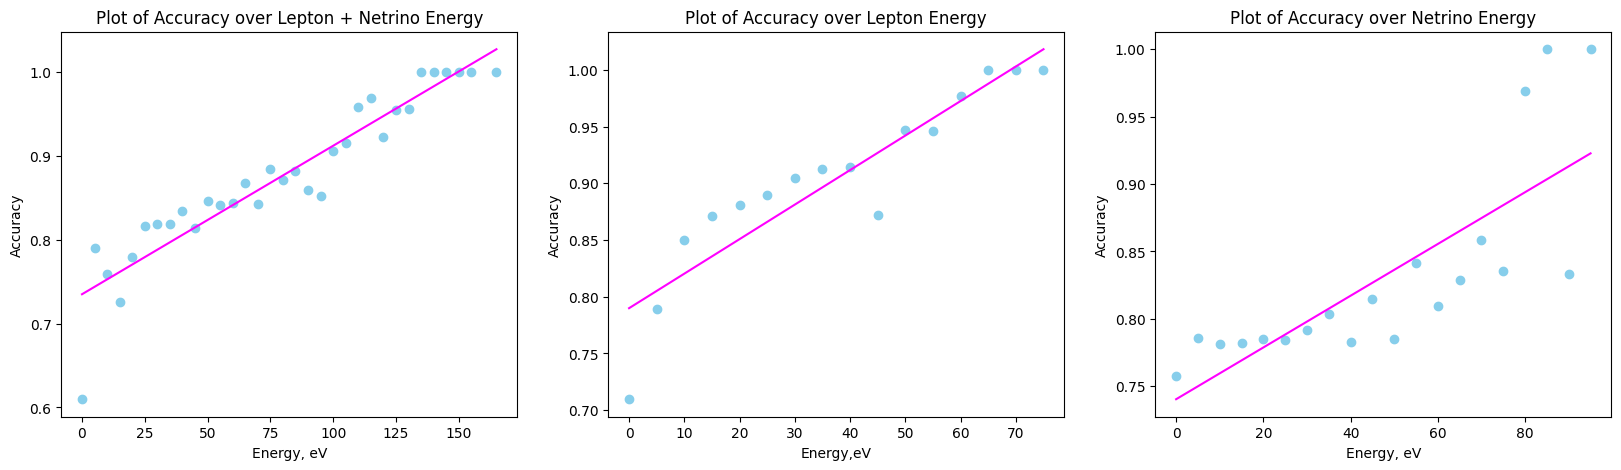

In [ ]:
# Plot of energy accuracies
fig, ax = plt.subplots(1,3, figsize=(20,5))

ax[0].plot(energy5_keys[:-1], energy5_acc[:-1],'o', c='skyblue')
ax[0].plot(energy_x,  energy_y,c='magenta')

# Setting axis and labels
ax[0].set_xlabel('Energy, eV')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Plot of Accuracy over Lepton + Netrino Energy')

ax[1].plot(lepenergy5_keys[:-1],  lepenergy5_acc[:-1],'o',c='skyblue')
ax[1].plot(lep_x,  lep_y,c='magenta')

# Setting axis and labels
ax[1].set_xlabel('Energy,eV')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Plot of Accuracy over Lepton Energy')

ax[2].plot(nuenergy5_keys,   nuenergy5_acc,'o',c='skyblue')
ax[2].plot(nu_x,  nu_y,c='magenta')
# Setting axis and labels

ax[2].set_xlabel('Energy, eV')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Plot of Accuracy over Netrino Energy')

plt.show()

*As it can be infer from the images accuracy imrpoves significantly with energy fro btoh neutrinos and leptons.(...)*

# PERFORMANCE OVER DIFFERENT META-DATA VARIABLES

In [ ]:
# Meta data accuracies
finalstate_keys, finalstate_acc           = meta_data_acc('finalstate',      event_labels_dic, event_scores_dic, 0.5)
finalstateprong_keys, finalstateprong_acc = meta_data_acc('finalstateprong', event_labels_dic, event_scores_dic, 0.5)
parent_keys,          parent_acc          = meta_data_acc('parent',          event_labels_dic, event_scores_dic, 0.5)
evt_keys,             evt_acc             = meta_data_acc('evt',             event_labels_dic, event_scores_dic, 0.5)
run_keys,             run_acc             = meta_data_acc('run',             event_labels_dic, event_scores_dic, 0.5)
subevt_keys,             subevt_acc             = meta_data_acc('subevt',             event_labels_dic, event_scores_dic, 0.5)
particles_keys,       particles_acc       = meta_data_acc('particles',       event_labels_dic, event_scores_dic, 0.5)

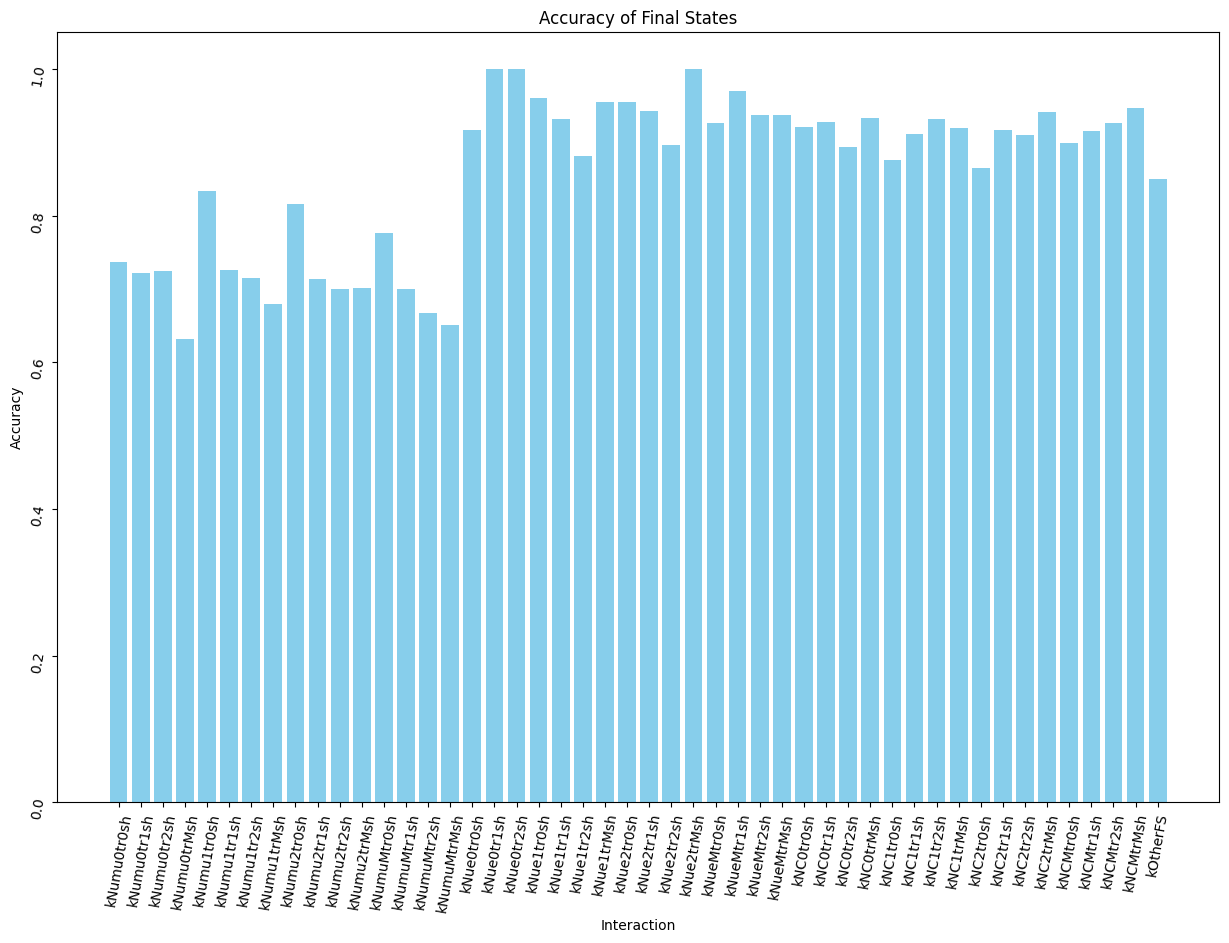

In [ ]:
# Encode labels for finals states
finalstate_names = np.array([FinalState(i).name for i in finalstate_keys])
FinalState_keys = np.array([FinalState(i).name for i in finalstate_keys])


# Final state accuracies
fig, ax = plt.subplots(1,1, figsize=(15,10))

# Bar plot
ax.bar(finalstate_names, finalstate_acc, color='skyblue')
ax.tick_params(labelrotation=80)

# Set labels and titles 
ax.set_title('Accuracy of Final States')
ax.set_xlabel('Interaction')
ax.set_ylabel('Accuracy')

plt.show()


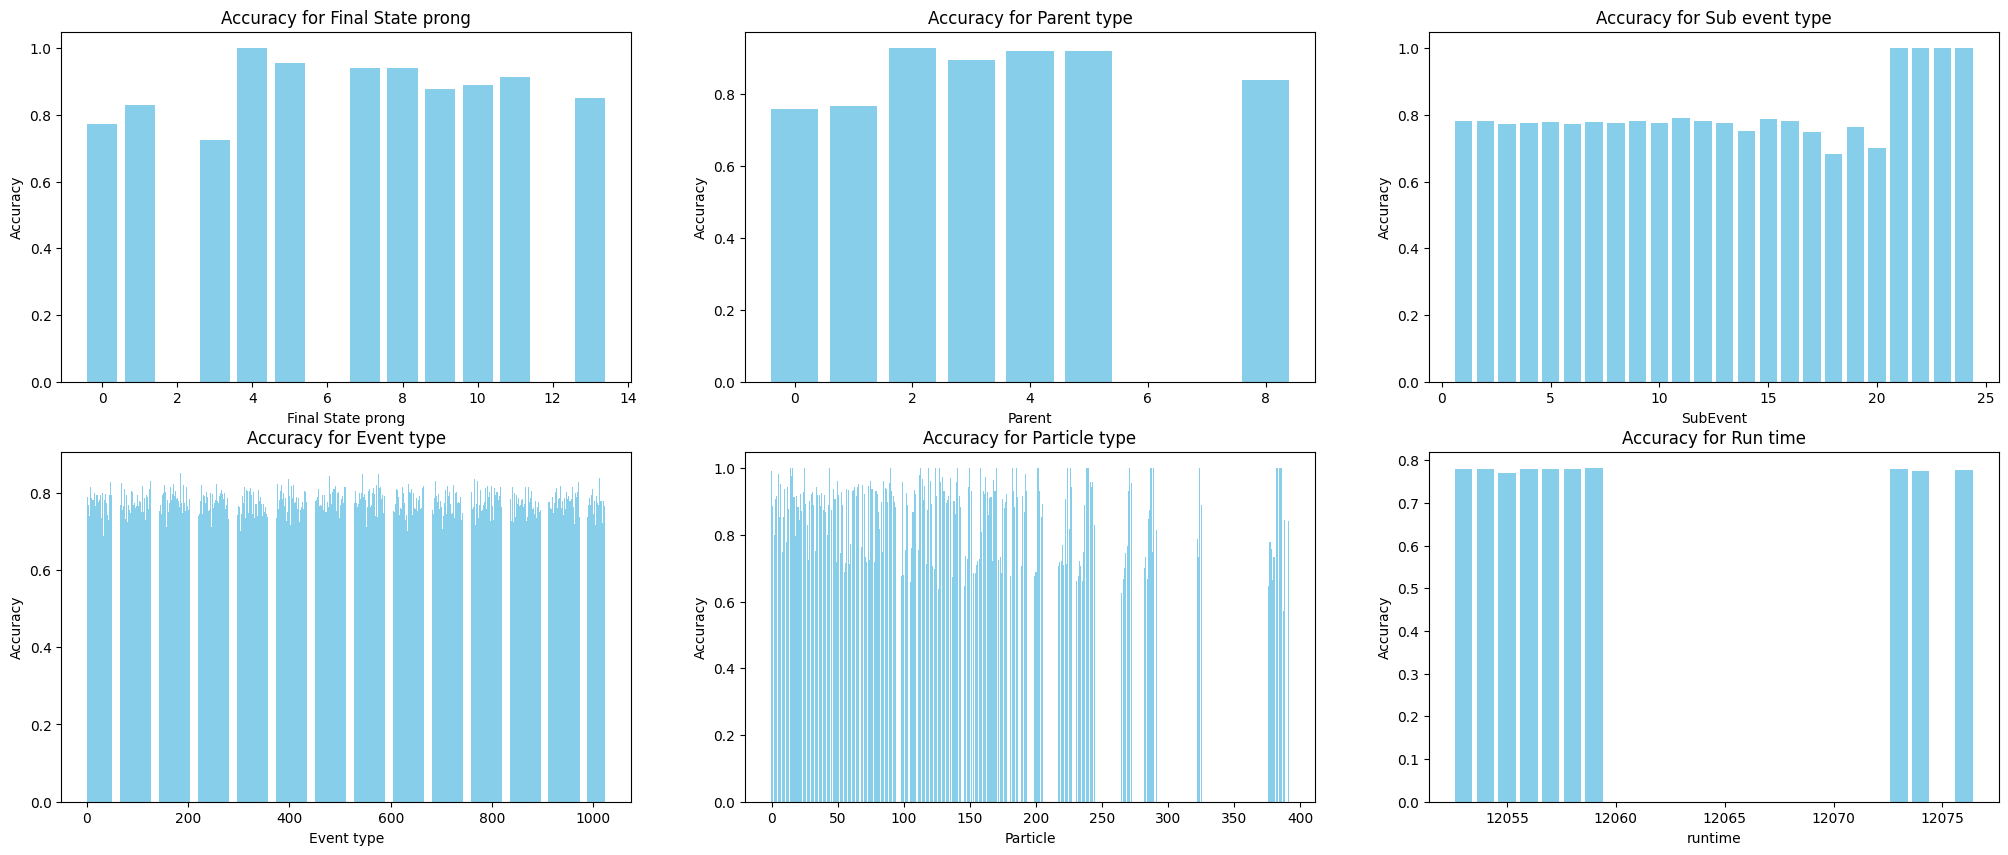

In [ ]:
# Plot final state accuracies
fig, ax = plt.subplots(2, 3, figsize=(25,10))

ax[0,0].bar(finalstateprong_keys, finalstateprong_acc, color='skyblue')
ax[0,0].set_title('Accuracy for Final State prong')
ax[0,0].set_xlabel('Final State prong')
ax[0,0].set_ylabel('Accuracy')

ax[0,1].bar(parent_keys,  parent_acc, color='skyblue')
ax[0,1].set_title('Accuracy for Parent type')
ax[0,1].set_xlabel('Parent')
ax[0,1].set_ylabel('Accuracy')

ax[1,0].bar(evt_keys,   evt_acc, color='skyblue')
ax[1,0].set_title('Accuracy for Event type')
ax[1,0].set_xlabel('Event type')
ax[1,0].set_ylabel('Accuracy')


ax[1,1].bar(particles_keys,   particles_acc, color='skyblue')
ax[1,1].set_title('Accuracy for Particle type')
ax[1,1].set_xlabel('Particle')
ax[1,1].set_ylabel('Accuracy')

ax[0,2].bar(subevt_keys, subevt_acc, color='skyblue')
ax[0,2].set_title('Accuracy for Sub event type')
ax[0,2].set_xlabel('SubEvent')
ax[0,2].set_ylabel('Accuracy')

ax[1,2].bar(run_keys, run_acc, color='skyblue')
ax[1,2].set_title('Accuracy for Run time')
ax[1,2].set_xlabel('runtime')
ax[1,2].set_ylabel('Accuracy')


plt.show()

# Conclusions

The performance of the code was quite good, achieving an accuracy of 83%. This is a promising result, indicating that the model was able to effectively classify the images.

Furthermore, the meta data exploration provided valuable insights into the data and its features. This information could be useful for further refining the model or for gaining a better understanding of the underlying data.

Overall, these findings suggest that it was successful in achieving its goals and that the code performed well in classifying the data.


# EXTENSIONS

*For the extensions since we will vary the loaders quite a lot to use more or less data.*

*Let's create first a new loader.*

In [ ]:

def data_loader(file_n):
  """
  This function takes the number of files to be retrieved as an input and 
  retrieves the data and returns the file names in an array  

  Args:
  file_n -----> number of files

  Returns:
  files -------> array with the name of the files corresponding to file_n number

  """
  link_base = 'http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino'
  count = 1
  f_type = '.h5' # Files are h5
  files=[]  # Storage for the files being retreived 
  
  # Iterating over the number of files requested 
  for i in tqdm(range(0,file_n)):

          file_name = "neutrino" + str(count) + f_type # BEFORE IT WAS .h5                # obtaining the name of the link of the file 
          files.append(file_name)                                     # appending the name to the array of filenames 
          urllib.request.urlretrieve(link_base+str(count)+f_type, file_name) # retriving the data of the files
          count += 1                                                # increasing the counter by 1 
          
  return (files)

MODEL ARCHITECTURE FUNCTIONS FOR EXTENSIONS

In [ ]:
def conv_block(input_img, input_shape):

  """
  This function creates a simple Convolutional Neural Network model in keras using the functional API.

  Args:
  - input_img: image to be fed into the network, either the x-z view of the interaction or the y-z view.
  - input_shape: shape of the images being fed into the network.

  Returns:
  - model: CNN model  

  """
   

  # Conv2D layer is used for images.  
  model = Conv2D(16, (3, 3),                                                     # Using a filter size of 16, kernel size of (3,3)
                 activation = "relu",                                           # Rectified Linear Unit as activation function
                 padding='same', input_shape=input_shape[1:])(input_img)        # Keeping the padding 'same' allows to preserve spatial dimension
  # Max pooling operation for 2D spatial data.
  model = MaxPooling2D((2, 2),                                                  # Pool size of (2,2)
                       padding='same')(model)                                   # Keeping the padding 'same' allows to preserve spatial dimension
  # Regularization technique for the model
  model = Dropout(0.25)(model)                                                  # 25% of the data is randomly excluded 

  # Add additional convolutional layers
  model = Conv2D(32, (3, 3),                                                    # Using a filter size of 32, kernel size of (3,3)
                 activation = "relu",                                           # Rectified Linear Unit as activation function
                 padding='same')(model)                                         # Keeping the padding 'same' allows to preserve spatial dimension
  model = MaxPooling2D((2, 2),                                                  # Pool size of (2,2)
                       padding='same')(model)                                   # Keeping the padding 'same' allows to preserve spatial dimension
  model = Dropout(0.25)(model)                                                  # 25% of the data is randomly excluded 

  model = Conv2D(64, (3, 3),                                                    # Using a filter size of 64, kernel size of (3,3)
                 activation = "relu",                                           # Rectified Linear Unit as activation function
                 padding='same')(model)                                         # Keeping the padding 'same' allows to preserve spatial dimension
  model = MaxPooling2D((2, 2),                                                  # Pool size of (2,2)
                       padding='same')(model)                                   # Keeping the padding 'same' allows to preserve spatial dimension
  model = Dropout(0.4)(model)                                                   # 40% of the data is randomly excluded    

  return model

def model_regression(input_shape):
  
  """
  This function creates a slightly more complex Convolutional Neural Network model specifically for regression tasks in keras 
  using the functional API for both the views of the neutrino interactions, for the x-y view and the y-z view, and concatenates them. 

  Input:
  - input_shape: shape of the images being fed into the network.

  Output:
  - model: CNN model of concatenated x-z and y-z views of the neutrino interactions.

  """
  # Creates the CNN model for the x-z view of the neutrino interaction.
  xz_input = Input(shape=input_shape[1:])
  xz_model = Conv2D(16, (3, 3), activation='relu', padding='same')(xz_input)
  xz_model = MaxPooling2D((2, 2), padding='same')(xz_model)
  xz_model = Conv2D(32, (3, 3), activation='relu', padding='same')(xz_model)
  xz_model = MaxPooling2D((2, 2), padding='same')(xz_model)
  xz_model = Conv2D(32, (3, 3), activation='relu', padding='same')(xz_model)
  xz_model = MaxPooling2D((2, 2), padding='same')(xz_model)
  xz_model = Flatten()(xz_model)
  xz_model = Dropout(0.4)(xz_model)

  # Creates the CNN model for the y-z view of the neutrino interaction.
  yz_input = Input(shape=input_shape[1:])
  yz_model = Conv2D(16, (3, 3), activation='relu', padding='same')(yz_input)
  yz_model = MaxPooling2D((2, 2), padding='same')(yz_model)
  yz_model = Conv2D(32, (3, 3), activation='relu', padding='same')(yz_model)
  yz_model = MaxPooling2D((2, 2), padding='same')(yz_model)
  yz_model = Conv2D(32, (3, 3), activation='relu', padding='same')(yz_model)
  yz_model = MaxPooling2D((2, 2), padding='same')(yz_model)
  yz_model = Flatten()(yz_model)
  yz_model = Dropout(0.4)(yz_model)

  # Concatenates the two models 
  conv = concatenate([xz_model, yz_model])

  # Dense layers connect all the neurons of one layer to the ones in the next layer 
  dense = Dense(32, activation='relu')(conv)
  dense = Dropout(0.4)(dense)
  dense = Dense(16, activation='relu')(dense)
  dense = Dropout(0.4)(dense)

  output = Dense(1, activation='linear')(dense)

  # creates the model using the two model inputs 
  model = Model(inputs=[xz_input, yz_input], outputs=output)

 

  model.summary()

  return model


def data (model_input_1, model_input_2, model_labels, train_frac, val_frac):

  """
  This function takes the labels and the two sets of corresponding images as an input and puts them into separate arrays,
  splits the data into training, testing and validation data sets, normalizes the images to be between 0 and 1 pixels and 
  puts all the data in the same format. It prepares the data to be fed into the neural network. 

  Args:
  - model_labels: labels of the neutrino interactions.
  - model_input_1: images corresponding to the x-z view of the interaction.
  - model_input_2: images corresponding to the y-z view of the interaction.
  - train_frac: fraction to split the data into training and testing data. If 80% is used, 80% will be used for training and 20% for testing. 
  - val_fraction: fraction to split the training data into training and validation data. 

  Return:
  - train_input_1: training data corresponding to the x-z view of the interaction. 
  - test_input_1: testing data corresponding to the x-z view of the interaction. 
  - val_input_1: validation data corresponding to the x-z view of the interaction. 
  - train_input_2: training data corresponding to the y-z view of the interaction. 
  - test_input_2: testing data corresponding to the y-z view of the interaction. 
  - val_input_2: validation data corresponding to the y-z view of the interaction. 
  - train_labels: training labels of the interaction. 
  - val_labels: validation labels of the interaction.  
  - test_labels: testing labels of the interaction. 

  """

  # Making arrays of all the data 
  model_in_1 = np.array(model_input_1)
  model_in_2 = np.array(model_input_2)
  model_lab = np.array(model_labels)
  
  # Splitting the data into train and test data
  tr_input_1, te_input_1 = train_test_split(model_in_1, train_size = train_frac, shuffle = False)
  tr_input_2, te_input_2 = train_test_split(model_in_2, train_size = train_frac, shuffle = False)
  tr_labels, te_labels = train_test_split(model_lab, train_size = train_frac, shuffle = False)

  # Splitting the data into training and validation data sets
  train_input_1, val_input_1 = train_test_split(tr_input_1, train_size = val_frac, shuffle = False)
  train_input_2, val_input_2 = train_test_split(tr_input_2, train_size = val_frac, shuffle = False)
  train_labels, val_labels =train_test_split(tr_labels, train_size = val_frac, shuffle = False)
  
  # Normalizing the images to be between 0 and 1 pixels and converting the arrays to the same data type  
  norm=255.0
  train_input_1 = train_input_1.astype('float32') / norm
  val_input_1 = val_input_1.astype('float32') / norm
  test_input_1 = te_input_1.astype('float32') / norm

  train_input_2 = train_input_2.astype('float32') / norm
  val_input_2 = val_input_2.astype('float32') / norm
  test_input_2 = te_input_2.astype('float32') / norm

  train_labels = train_labels.astype('float32')
  val_labels = val_labels.astype('float32')
  test_labels = te_labels.astype('float32')

  return (train_input_1, test_input_1, val_input_1, train_input_2, test_input_2, val_input_2, train_labels, val_labels, test_labels)

## FUNCTION TO SHUFFLE THE IMAGES AND LABELS TOGETHER 

def shuffle_data(labels, image_set_1, image_set_2):
    """
    Shuffle the labels and corresponding images together.

    Args:
    - labels: A list or array of labels for the images.
    - image_set_1: A list or array of images corresponding to the x-z view of the interaction.
    - image_set_2: A list or array of images corresponding to the y-z view of the interaction.

    Returns:
    - A tuple of shuffled lists or arrays, containing the shuffled labels, image_set_1 and image_set_2.
    """
    
    # Zip the labels and image sets together
    zip_data = list(zip(labels, image_set_1, image_set_2))
    
    # Shuffle the zipped data
    np.random.shuffle(zip_data)
    
    # Unzip the shuffled data
    shuffled_labels, shuffled_image_set_1, shuffled_image_set_2 = zip(*zip_data)
    
    return shuffled_labels, shuffled_image_set_1, shuffled_image_set_2



# *EXTENSION 1*
## Write a machine learning algorithm to determine the energy of the neutrino

*For this task we will create new data and train a linear regression CNN with the neutrino energies as the target values*

           notice the CNN model will be less complex than the inception module




In [ ]:
files_e1 = data_loader(12)

100%|██████████| 12/12 [00:15<00:00,  1.28s/it]


Get from the files the neutrino energies and the input images.

In [ ]:
# STORAGE
nu_energy_target = []
nu_E_event_1 = []
nu_E_event_2 = []

for filename in tqdm(files_e1):

  # File in read mode 
  df=h5py.File(filename, 'r')

  # Loop over the images:
  for i in range(len(df['cvnmap'])):

    item = df['cvnmap'][i].reshape((2,100,80)) # reshape images to 100x80 pix
    nu_E_event_1.append(item[0]) # channel x-z of image
    nu_E_event_2.append(item[1]) # channel y-z of image
    nu_energy_target.append(int(df['neutrino']['nuenergy'][i])) # value of neutrino energy

100%|██████████| 12/12 [05:56<00:00, 29.68s/it]


In [ ]:
#PREPARATION

# expanding the dimensions of the images corresponding to the x-z view of the neutrino interaction
nu_E_event_1 = tf.expand_dims(nu_E_event_1, axis = 3)

# expanding the dimensions of the images corresponding to the y-z view of the neutrino interaction
nu_E_event_2 = tf.expand_dims(nu_E_event_2, axis = 3)

#NORMALISE ENERGIES
nu_energy_target = nu_energy_target/np.max(nu_energy_target)

# SPLIT
train_input_1_nuenergy, test_input_1_nuenergy, val_input_1_nuenergy, train_input_2_nuenergy, test_input_2_nuenergy, val_input_2_nuenergy, train_labels_nuenergy, val_labels_nuenergy, test_labels_nuenergy = data(nu_E_event_1, nu_E_event_2, nu_energy_target, 0.8, 0.8)


In [ ]:

model_e1 = model_regression(nu_E_event_1.shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 80, 16)  160         ['input_1[0][0]']                
                                                                                              

In [ ]:
# compiles the final model
model_e1.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['mae', 'mse'])

In [ ]:
# Monitoring val_loss, if there is no improvement after 5 epochs the model stops there and uses the weights of the last improvement
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",                       
                                        mode ="min",                               
                                        patience = 5,                              
                                        restore_best_weights = True)          

history_E1 = model_e1.fit(x=[train_input_1_nuenergy,train_input_2_nuenergy],
                    y=train_labels_nuenergy, batch_size=32,         
                    epochs=30,                                            
                    validation_data=([val_input_1_nuenergy,val_input_2_nuenergy],
                                     val_labels_nuenergy),
                    callbacks =[earlystopping] )                                   

Epoch 1/30
1659/1659 [==============================] - 58s 34ms/step - loss: 0.0118 - mae: 0.0814 - mse: 0.0118 - val_loss: 0.0107 - val_mae: 0.0771 - val_mse: 0.0107
Epoch 2/30
1659/1659 [==============================] - 55s 33ms/step - loss: 0.0111 - mae: 0.0787 - mse: 0.0111 - val_loss: 0.0109 - val_mae: 0.0771 - val_mse: 0.0109
Epoch 3/30
1659/1659 [==============================] - 54s 33ms/step - loss: 0.0109 - mae: 0.0780 - mse: 0.0109 - val_loss: 0.0103 - val_mae: 0.0755 - val_mse: 0.0103
Epoch 4/30
1659/1659 [==============================] - 55s 33ms/step - loss: 0.0108 - mae: 0.0773 - mse: 0.0108 - val_loss: 0.0112 - val_mae: 0.0759 - val_mse: 0.0112
Epoch 5/30
1659/1659 [==============================] - 55s 33ms/step - loss: 0.0107 - mae: 0.0769 - mse: 0.0107 - val_loss: 0.0104 - val_mae: 0.0733 - val_mse: 0.0104
Epoch 6/30
1659/1659 [==============================] - 55s 33ms/step - loss: 0.0106 - mae: 0.0765 - mse: 0.0106 - val_loss: 0.0103 - val_mae: 0.0741 - val_mse:

Text(0.5, 1.0, 'MSE of regression CNN for neutrino energy')

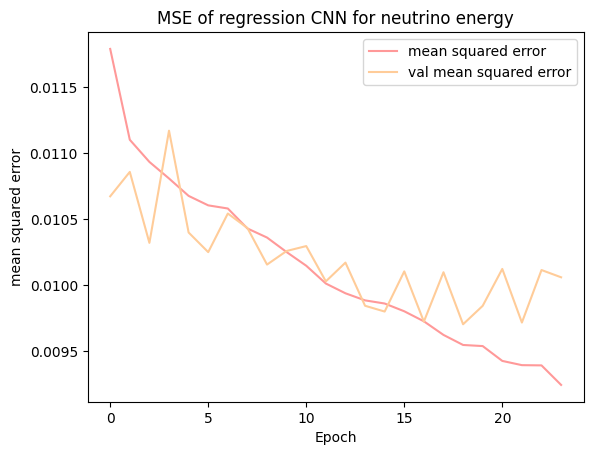

In [ ]:
## PLOTTING THE MSE OF THE MODEL 
plt.plot(history_E1.history['mse'], label='mean squared error',c='#ff9999')
plt.plot(history_E1.history['val_mse'], label = 'val mean squared error',c='#ffcc99')
plt.xlabel('Epoch')
plt.ylabel('mean squared error')
plt.legend(loc='upper right')
plt.title('MSE of regression CNN for neutrino energy')

Text(0.5, 1.0, 'MAE of regression model for neutrino energy')

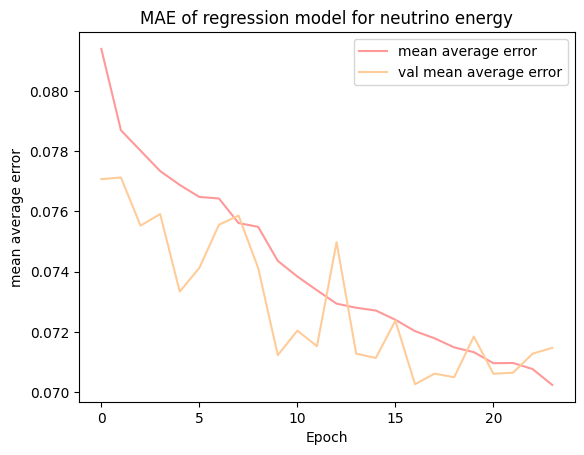

In [ ]:
## PLOTTING THE MAE OF THE MODEL 

plt.plot(history_E1.history['mae'], label='mean average error',c='#ff9999')
plt.plot(history_E1.history['val_mae'], label = 'val mean average error',c='#ffcc99')
plt.xlabel('Epoch')
plt.ylabel('mean average error')
plt.legend(loc='upper right')

plt.title('MAE of regression model for neutrino energy')

In [ ]:
# EVALUATION
test_loss_e1, test_mae_e1, test_mse_e1 = model_e1.evaluate([test_input_1_nuenergy,test_input_2_nuenergy],  test_labels_nuenergy, verbose=2)


519/519 - 4s - loss: 0.0094 - mae: 0.0698 - mse: 0.0094 - 4s/epoch - 9ms/step


# *EXTENSION 2*
## Write a machine learning algorithm to determine the flavour of the neutrino

In [ ]:

files_e2=data_loader(70)

100%|██████████| 70/70 [01:28<00:00,  1.27s/it]


In [ ]:
## SPLITTING THE FILES

files_e2_99, files_e2_01 = train_test_split(files_e2, train_size = 0.99)
files_e2_90, files_e2_10 = train_test_split(files_e2, train_size = 0.90)

In [ ]:
# STORAGES
e2_labels = [] #labels of the neutrino flavour
e2_input_1 = [] # x-z view of the neutrino interaction
e2_input_2 = [] # y-z view of the neutrino interaction

# Iterating over the array of file names images and labels
for filename in tqdm(files_e2_01):                              

  # opening the file in read only mode
  df=h5py.File(filename, 'r')

  # Looping over the neutrino interactions to obtain the labels and input images for each interaction 
  for i in range(len(df['neutrino']['interaction'])):

    # muon-neutrinos (0-3)
    if df['neutrino']['interaction'][i] <=3: 

      image = df['cvnmap'][i].reshape((2,100,80)) # reshaping the images
      e2_input_1.append(image[0]) # x-z view 
      e2_input_2.append(image[1]) # y-z view 
      # 1 for muon neutrinos
      e2_labels.append(int(1))                                            

    else:
      pass

# Iterating over the array of file names images and labels
for filename in tqdm(files_e2):  

  # opening the file in read only mode
  df=h5py.File(filename, 'r')

  # iterating over the neutrino interactions to obtain the labels and input images for each interaction
  for j in range(len(df['neutrino']['interaction'])):

    # electron-neutrinos (4-7)
    if df['neutrino']['interaction'][j] >=4 and df['neutrino']['interaction'][j] <= 7:

      image = df['cvnmap'][j].reshape((2,100,80))                         
      e2_input_1.append(image[0])                                         
      e2_input_2.append(image[1]) 
      # 2 for the electron neutrinos class                                       
      e2_labels.append(int(2))                                             
    else:
      pass

# Iterating over the array of file names images and labels
for filename in tqdm(files_e2_10):

  # opening the file in read only mode
  df=h5py.File(filename, 'r')

  # Looping over the  neutrino interactions to obtain the labels and input images for each interaction 
  for i in range(len(df['neutrino']['interaction'])):

    if df['neutrino']['interaction'][i] > 7:  

      model = df['cvnmap'][i].reshape((2,100,80))
      e2_input_1.append(model[0])
      e2_input_2.append(model[1]) 
      # 0 for for non-muon and non-electron neutrinos
      e2_labels.append(int(0))   

    else:
      pass

100%|██████████| 7/7 [00:32<00:00,  4.58s/it]


Text(0.5, 1.0, 'Labels for flavour classification')

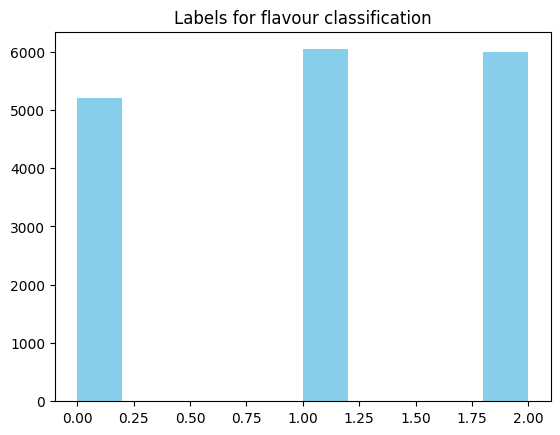

In [ ]:
## PLOTTING THE LABELS TO CHECK IF IT IS BALANCED 

plt.hist(e2_labels, color='skyblue')
plt.title('Labels for flavour classification')

In [ ]:
## PREPARING THE DATA TO FEED INTO THE NEURAL NETWORK

# shuffling the labels and images 
e2_labels, e2_input_1, e2_input_2 = shuffle_data(e2_labels, e2_input_1, e2_input_2)

# expanding the dimensions of the images corresponding to the x-z view of the neutrino interaction
e2_input_1 = tf.expand_dims(e2_input_1, axis = 3)

# expanding the dimensions of the images corresponding to the y-z view of the neutrino interaction
e2_input_2 = tf.expand_dims(e2_input_2, axis = 3)

# preparing the training, testing and validation data
train_input_1_e2, test_input_1_e2, val_input_1_e2, train_input_2_e2, test_input_2_e2, val_input_2_e2, train_labels_e2, val_labels_e2, test_labels_e2 = data(e2_input_1, e2_input_2, e2_labels, 0.8, 0.8)

# to be able to use categorical cross entropy since its a classification task
train_labels_e2 = tf.keras.utils.to_categorical(train_labels_e2, 3)
test_labels_e2 = tf.keras.utils.to_categorical(test_labels_e2, 3)
val_labels_e2 = tf.keras.utils.to_categorical(val_labels_e2, 3)

In [ ]:
# Creates the CNN model for the x-z view of the neutrino interaction.
xz_input = Input(shape=np.shape(e2_input_1)[1:])
xz_model = conv_block(xz_input, np.shape(e2_input_1)[1:])

# Creates the CNN model for the y-z view of the neutrino interaction.
yz_input = Input(shape=np.shape(e2_input_1)[1:])
yz_model = conv_block(yz_input, np.shape(e2_input_1)[1:])

# Concatenates the two models 
conv = concatenate([xz_model, yz_model])

# Flattens the concatenated models 
conv = Flatten()(conv)

# Dense layers connect all the neurons of one layer to the ones in the next layer 
dense = Dense(32, activation='relu')(conv) 
dense = Dropout(0.5)(dense)

output = Dense(3, activation='sigmoid')(dense)

# creates the model using the two model inputs 
model_e2 = Model(inputs=[xz_input, yz_input], outputs=output)

# compiles the final model
model_e2.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

model_e2.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_17 (InputLayer)          [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_50 (Conv2D)             (None, 100, 80, 16)  160         ['input_16[0][0]']               
                                                                                            

In [ ]:
# Monitoring val_loss, if there is no improvement after 5 epochs the model stops there and uses the weights of the last improvement
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",                       
                                        mode ="min",                               
                                        patience = 5,                              
                                        restore_best_weights = True)             

history_E2 = model_e2.fit(x=[train_input_1_e2,train_input_2_e2],
                    y=train_labels_e2, batch_size=64,               
                    epochs=50,       
                    validation_data=([val_input_1_e2,val_input_2_e2],val_labels_e2),
                    callbacks =[earlystopping] )

Epoch 1/50
173/173 [==============================] - 15s 73ms/step - loss: 1.0013 - accuracy: 0.5010 - val_loss: 0.9463 - val_accuracy: 0.5428
Epoch 2/50
173/173 [==============================] - 12s 72ms/step - loss: 0.9334 - accuracy: 0.5429 - val_loss: 0.9000 - val_accuracy: 0.5519
Epoch 3/50
173/173 [==============================] - 13s 72ms/step - loss: 0.8851 - accuracy: 0.5694 - val_loss: 0.8520 - val_accuracy: 0.5911
Epoch 4/50
173/173 [==============================] - 12s 70ms/step - loss: 0.8496 - accuracy: 0.5913 - val_loss: 0.8164 - val_accuracy: 0.6052
Epoch 5/50
173/173 [==============================] - 12s 70ms/step - loss: 0.8286 - accuracy: 0.6046 - val_loss: 0.8041 - val_accuracy: 0.6125
Epoch 6/50
173/173 [==============================] - 12s 72ms/step - loss: 0.8076 - accuracy: 0.6165 - val_loss: 0.7999 - val_accuracy: 0.6136
Epoch 7/50
173/173 [==============================] - 12s 70ms/step - loss: 0.7901 - accuracy: 0.6273 - val_loss: 0.7855 - val_accuracy:

Text(0.5, 1.0, 'Accuracy of neutrino flavour classifier')

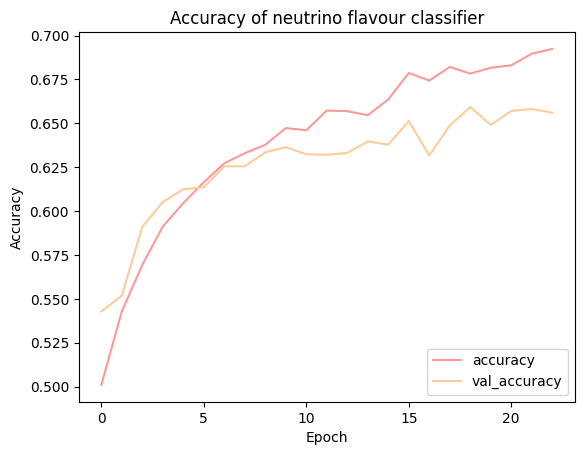

In [ ]:
## PLOTTING THE ACCURACY OF THE MODELc99'

plt.plot(history_E2.history['accuracy'], label='accuracy',c='#ff9999')
plt.plot(history_E2.history['val_accuracy'], label = 'val_accuracy',c='#ffcc99')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.title('Accuracy of neutrino flavour classifier')

Text(0.5, 1.0, 'Loss of neutrino flavour classifier')

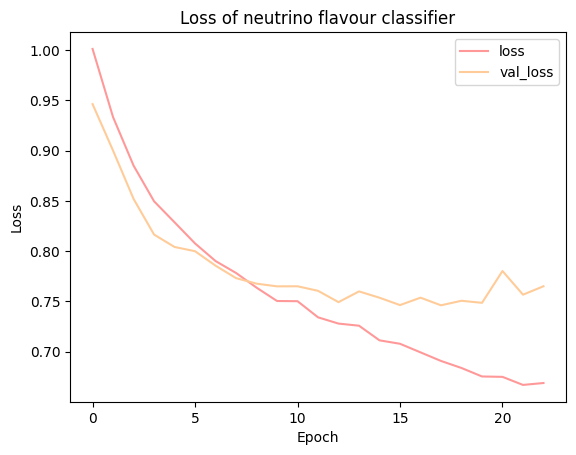

In [ ]:
## PLOTTING THE LOSS OF THE MODEL

plt.plot(history_E2.history['loss'], label='loss',c='#ff9999')
plt.plot(history_E2.history['val_loss'], label = 'val_loss',c='#ffcc99')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.title('Loss of neutrino flavour classifier')

In [ ]:
## EVALUATING THE ACCURACY AND LOSS OF THE MODEL 

test_loss, test_acc = model_e2.evaluate([test_input_1_e2,test_input_2_e2],  test_labels_e2, verbose=2)

108/108 - 1s - loss: 0.7387 - accuracy: 0.6625 - 970ms/epoch - 9ms/step


# *EXTENSION 3*
## Machine learning algorithm to determine 𝑦= lepton energy over neutrino energy

*The first step is to determine if any interaction has 0 lepton or neutrino energy to therefore dont take it into account*

In [ ]:
# Study a large set of data so that our observations are not biased
files_e3_finder=data_loader(200)

100%|██████████| 200/200 [04:15<00:00,  1.28s/it]


*Check if for any interaction there is 0 letpon and neutrino energy*

In [ ]:
## FINDING INTERACTIONS WITH 0 LEPTON ENERGY AND 0 NEUTRINO ENERGY  

# create empty lists to store the number of the interaction with 0 lepton energy and 0 neutrino energy
lep_energy_zero = []
nu_energy_zero = []

# iterate over the array of file names to obtain the labels and the input images for each interaction
for filename in tqdm(files_e3_finder):

    # open the file in read-only mode
    with h5py.File(filename, 'r') as file:

        # iterate over the length of neutrino interactions to obtain the labels and input images for each interaction 
        for i in range(len(file['cvnmap'])):

            # if the lepton energy is 0, append the number of the interaction to the lep_energy_zero list
            if file['neutrino']['lepenergy'][i] == 0:
                lep_energy_zero.append(file['neutrino']['interaction'][i])

            # if the neutrino energy is 0, append the number of the interaction to the nu_energy_zero list
            if file['neutrino']['nuenergy'][i] == 0:
                nu_energy_zero.append(file['neutrino']['interaction'][i])


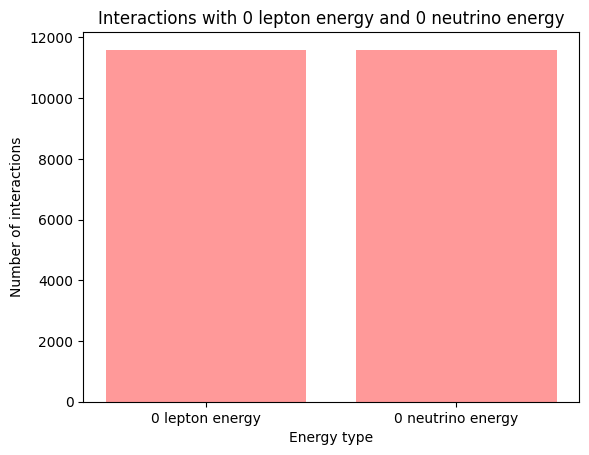

Interaction 15 has 0 lepton, neutrino energy


In [ ]:
# Check if interaction 15 has 0 lepton energy and 0 neutrino energy
interaction_15_energy = []
if 15 in lep_energy_zero:
    interaction_15_energy.append('lepton')
if 15 in nu_energy_zero:
    interaction_15_energy.append('neutrino')

# Create a bar plot to show the number of interactions with 0 lepton energy and 0 neutrino energy
labels = ['0 lepton energy', '0 neutrino energy']
values = [len(lep_energy_zero), len(nu_energy_zero)]
plt.bar(labels, values, color='#ff9999')
plt.title('Interactions with 0 lepton energy and 0 neutrino energy')
plt.xlabel('Energy type')
plt.ylabel('Number of interactions')
plt.show()

# Print if interaction 15 has 0 lepton energy and/or 0 neutrino energy
if interaction_15_energy:
    print(f'Interaction 15 has 0 {", ".join(interaction_15_energy)} energy')
else:
    print('Interaction 15 has non-zero energy for both lepton and neutrino')



In [ ]:
## RETRIEVING THE NECESSARY FILES 

files_e3=data_loader(6)

100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


In [ ]:
# LABELS AND IMAGES INPUT FOR MODEL 

y_E_target = [] # Storage lepton energy over neutrino energy 
y_E_input_1=[]  # Storage for the x-z view of the neutrino interaction
y_E_input_2=[]  # Storage for the y-z view of the neutrino interaction

# iterating over the array of file names to obtain the lables and the input images for each interaction
for filename in tqdm(files_e3):

  # reading mode
  df=h5py.File(filename, 'r')

  # iterating over the length of the images to get the labels and input images for each interaction 
  for i in range(len(df['cvnmap'])):

    # EXCLUDING INTERACTION 15 
    if df['neutrino']['interaction'][i] < 15 or df['neutrino']['interaction'][i] == 16:
      
      # calculating lepton energy over neutrino energy 
      y = df['neutrino']['lepenergy'][i] / df['neutrino']['nuenergy'][i] 
      
      y_E_target.append(y) # apending y to the label array
      image = df['cvnmap'][i].reshape((2,100,80)) # reshaping the images 100x80 pix
      y_E_input_1.append(image[0])
      y_E_input_2.append(image[1])     
    else:
      pass

100%|██████████| 6/6 [03:17<00:00, 32.87s/it]


In [ ]:
## PREPARING THE DATA TO FEED INTO THE NEURAL NETWORK

# expanding the dimensions of the images corresponding to the x-z view of the neutrino interaction
y_energy_input_1 = tf.expand_dims(y_E_input_1, axis = 3)

# expanding the dimensions of the images corresponding to the y-z view of the neutrino interaction
y_energy_input_2 = tf.expand_dims(y_E_input_2, axis = 3)

# normalizing the energy labels 
y_energy_labels=y_E_target/np.max(y_E_target)
y_energy_input_1 = y_energy_input_1.numpy()
y_energy_input_2 = y_energy_input_2.numpy()


# preparing the training, testing and validation data
train_input_1_y_energy, test_input_1_y_energy, val_input_1_y_energy, train_input_2_y_energy, test_input_2_y_energy, val_input_2_y_energy, train_labels_y_energy, val_labels_y_energy, test_labels_y_energy = data(y_energy_input_1, y_energy_input_2, y_energy_labels, 0.8, 0.8)

In [ ]:
## CREATING THE MODEL FOR LEPTON ENERGY OVER NEUTRINO ENERGY DETERMINATION 


model_e3 = model_regression(y_energy_input_1.shape)
model_e3.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['mae', 'mse'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 80, 16)  160         ['input_1[0][0]']                
                                                                                              

In [ ]:
# Monitoring val_loss, if there is no improvement after 5 epochs the model stops there and uses the weights of the last improvement


earlystopping = callbacks.EarlyStopping(monitor ="val_loss",                       
                                        mode ="min",                               
                                        patience = 5,                             
                                        restore_best_weights = True)        

history_E3 = model_e3.fit(x=[train_input_1_y_energy,train_input_2_y_energy],
                    y=train_labels_y_energy, batch_size=32,   
                    epochs=50,               
                    validation_data=([val_input_1_y_energy,val_input_2_y_energy],
                                     val_labels_y_energy),
                    callbacks =[earlystopping] )    

Epoch 1/50
829/829 [==============================] - 31s 34ms/step - loss: 0.0774 - mae: 0.2280 - mse: 0.0774 - val_loss: 0.0474 - val_mae: 0.1837 - val_mse: 0.0474
Epoch 2/50
829/829 [==============================] - 28s 34ms/step - loss: 0.0545 - mae: 0.1944 - mse: 0.0545 - val_loss: 0.0481 - val_mae: 0.1861 - val_mse: 0.0481
Epoch 3/50
829/829 [==============================] - 28s 34ms/step - loss: 0.0501 - mae: 0.1862 - mse: 0.0501 - val_loss: 0.0462 - val_mae: 0.1803 - val_mse: 0.0462
Epoch 4/50
829/829 [==============================] - 28s 34ms/step - loss: 0.0488 - mae: 0.1833 - mse: 0.0488 - val_loss: 0.0442 - val_mae: 0.1750 - val_mse: 0.0442
Epoch 5/50
829/829 [==============================] - 29s 35ms/step - loss: 0.0480 - mae: 0.1818 - mse: 0.0480 - val_loss: 0.0454 - val_mae: 0.1796 - val_mse: 0.0454
Epoch 6/50
829/829 [==============================] - 28s 34ms/step - loss: 0.0472 - mae: 0.1795 - mse: 0.0472 - val_loss: 0.0448 - val_mae: 0.1784 - val_mse: 0.0448
Epoc

Text(0.5, 1.0, 'MSE of the model to determine \n lepton energy over neutrino energy')

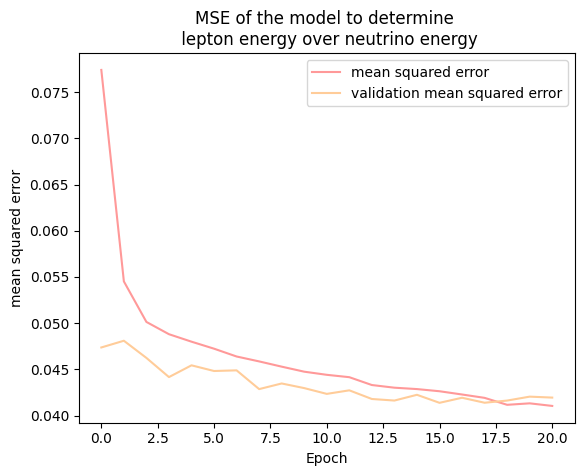

In [ ]:
## PLOTTING THE MSE OF THE MODEL 
plt.plot(history_E3.history['mse'], label='mean squared error',c='#ff9999')
plt.plot(history_E3.history['val_mse'], label = 'validation mean squared error',c='#ffcc99')
plt.xlabel('Epoch')
plt.ylabel('mean squared error')
plt.legend(loc='upper right')

plt.title('MSE of the model to determine \n lepton energy over neutrino energy')
#f.savefig("dataset.png")                # saves the figure to be able to download it to a desktop 
#files.download("dataset.png")           # saves the figure to the desktop and sets the name for it

Text(0.5, 1.0, 'MAE of the model to determine \n lepton energy over neutrino energy')

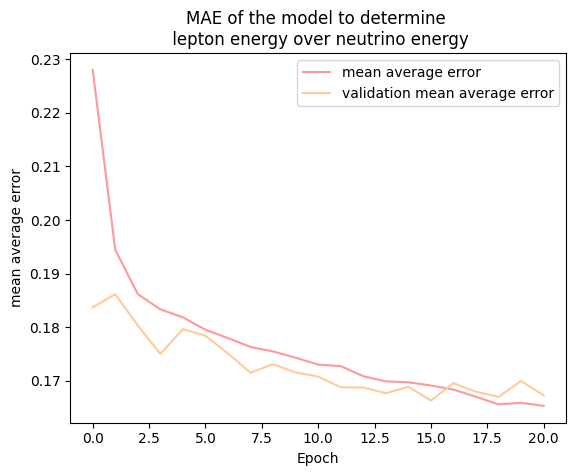

In [ ]:
## PLOTTING THE MAE OF THE MODEL 

plt.plot(history_E3.history['mae'], label='mean average error',c='#ff9999')
plt.plot(history_E3.history['val_mae'], label = 'validation mean average error',c='#ffcc99')
plt.xlabel('Epoch')
plt.ylabel('mean average error')
plt.legend(loc='upper right')

plt.title('MAE of the model to determine \n lepton energy over neutrino energy')

In [ ]:
# EVALUATION
test_loss, test_mae, test_mse = model_e3.evaluate([test_input_1_y_energy,test_input_2_y_energy],  test_labels_y_energy, verbose=2)

# *EXTENSION 5*
## Machine learning algorithm to determine the interaction mode

Develop an algorithm to classify the neutrino interaction model. 

This is a classification task with five classes in this case.

 The different interaction modes and the corresponding labels are shown below: 

- Label 0 for charged-current quasi-elastic events

- Label 1 for charged-current resonant events 

- Label 2 for charged-current deep-inelastic scattering 

- Label 3 for charged-current other events 

- Label 4 for neutral charged current events 

In [ ]:
## RETRIEVING THE NECESSARY FILES FOR THIS EXTENSION 

files_e5=data_loader(20)

100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


In [ ]:
# Obtain labels for the interaction mode

# Initialize an empty array for the labels corresponding to the interaction mode
int_mode_labels = []

# Iterate over the array of file names to obtain the labels and input images for each interaction
for filename in tqdm(files_e5):
  
  # Open the file in read-only mode
  df = h5py.File(filename)
               
  # Iterate over the length of neutrino interactions to obtain the labels and input images for each interaction
  for i in range(len(df['neutrino']['interaction'])):
    
    # Append 0 for CC QE events
    if (df['neutrino']['interaction'][i]) == 0 or (df['neutrino']['interaction'][i]) == 4 or (df['neutrino']['interaction'][i]) == 8:
      int_mode_labels.append(int(0)) 
    
    # Append 1 for CC RES events
    elif (df['neutrino']['interaction'][i]) == 1 or (df['neutrino']['interaction'][i]) == 5 or (df['neutrino']['interaction'][i]) == 9:
      int_mode_labels.append(int(1))
    
    # Append 2 for CC DIS events
    elif (df['neutrino']['interaction'][i]) == 2 or (df['neutrino']['interaction'][i]) == 6 or (df['neutrino']['interaction'][i]) == 10:
      int_mode_labels.append(int(2))
    
    # Append 3 for CC other events
    elif (df['neutrino']['interaction'][i]) == 3 or (df['neutrino']['interaction'][i]) == 7 or (df['neutrino']['interaction'][i]) == 11:
      int_mode_labels.append(int(3))
    
    # Append 4 for NC events
    elif (df['neutrino']['interaction'][i]) == 12 or (df['neutrino']['interaction'][i]) == 13:
      int_mode_labels.append(int(4))
    
    # Skip any other events
    else:
      pass


100%|██████████| 20/20 [03:14<00:00,  9.74s/it]


Text(0.5, 1.0, 'Imbalanced labels for neutrino interaction mode')

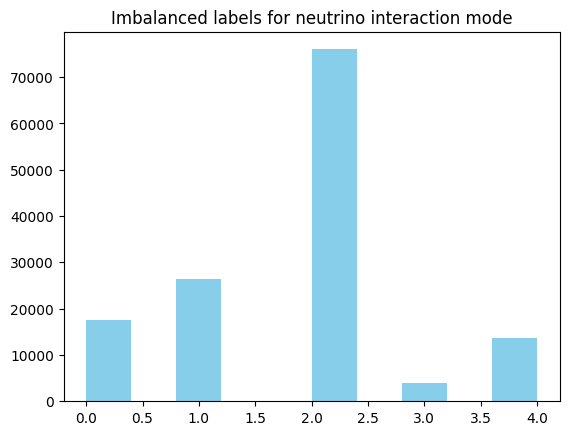

In [ ]:
## CHECKING IF THE LABELS ARE BALANCED 

plt.hist(int_mode_labels,color='skyblue')
plt.title('Imbalanced labels for neutrino interaction mode')

*Same method as before using different data to converge into a evenly distributed data*

In [ ]:
## SPLITTING THE FILES TO ITERATE OVER IN ORDER TO BALANCE THE LABELS

files_5_80, files_5_20 = train_test_split(files_e5, train_size = 0.8, shuffle = False)
files_5_95, files_5_05 = train_test_split(files_e5, train_size = 0.95, shuffle = False)
files_5_75, files_5_25 = train_test_split(files_e5, train_size = 0.75, shuffle = False)

In [ ]:
## GETTING THE LABELS FOR THE INTERACTION MODE CLASSIFIER AND BALANCING THEM 

#STORAGE
int_mode_labels_b=[]                                                
int_mode_input_1=[]                                                 
int_mode_input_2=[]                              

# iterating over the array of file names to obtain the lables and the input images for each interaction
for filename in tqdm(files_5_25):                                   # using 0-4 files 

  # opening the file in read only mode
  df=h5py.File(filename, 'r')

  # iterating over the length of neutrino interactions to obtain the labels and input images for each interaction 
  for i in range(len(df['neutrino']['interaction'])):

    # if the neutrino interaction number is 0, 4 or 8, the events is a CC QE event 
    if (df['neutrino']['interaction'][i]) == 0 or (df['neutrino']['interaction'][i]) == 4 or (df['neutrino']['interaction'][i]) == 8:

      model = df['cvnmap'][i].reshape((2,100,80))                  # reshaping the images
      int_mode_input_1.append(model[0])                            # apending the x-z view to the corresponding array
      int_mode_input_2.append(model[1])                            # apending the y-z view to the corresponding array
      int_mode_labels_b.append(int(0))                             # appending 0 for CC QE events

    else:
      pass


for filename in tqdm(files_5_20):                                  # using 0-3 files 

  # opening the file in read only mode
  df=h5py.File(filename, 'r')


  for i in range(len(df['neutrino']['interaction'])):

    # if the neutrino interaction number is 1, 5 or 9, the events is a CC RES event 
    if (df['neutrino']['interaction'][i]) == 1 or (df['neutrino']['interaction'][i]) == 5 or (df['neutrino']['interaction'][i]) == 9:

      int_mode_labels_b.append(int(1))                             # appending 1 for CC RES events 
      model = df['cvnmap'][i].reshape((2,100,80))                  
      int_mode_input_1.append(model[0])                            
      int_mode_input_2.append(model[1])                            

    else:
      pass


for filename in tqdm(files_5_05):                                  # using 0-1 files 

  # opening the file in read only mode
  df=h5py.File(filename, 'r')

  # iterating over the length of neutrino interactions to obtain the labels and input images for each interaction
  for i in range(len(df['neutrino']['interaction'])): 
    
    # if the neutrino interaction number is 2, 6 or 10, the events is a CC DIS event 
    if (df['neutrino']['interaction'][i]) == 2 or (df['neutrino']['interaction'][i]) == 6 or (df['neutrino']['interaction'][i]) == 10:

      int_mode_labels_b.append(int(2))                             # appending 2 for CC DIS events  
      model = df['cvnmap'][i].reshape((2,100,80))                 
      int_mode_input_1.append(model[0])                           
      int_mode_input_2.append(model[1])                           

    else:
      pass


for filename in tqdm(files_e5):                                     # using 0-15 files 

  # opening the file in read only mode
  df=h5py.File(filename, 'r')

  # iterating over the length of neutrino interactions to obtain the labels and input images for each interaction
  for i in range(len(df['neutrino']['interaction'])):

    # if the neutrino interaction number is 3, 7 or 11, the events is a CC other event
    if (df['neutrino']['interaction'][i]) == 3 or (df['neutrino']['interaction'][i]) == 7 or (df['neutrino']['interaction'][i]) == 11:

      int_mode_labels_b.append(int(3))                             # appending 3 for CC other events 
      model = df['cvnmap'][i].reshape((2,100,80))                  
      int_mode_input_1.append(model[0])   
      int_mode_input_2.append(model[1])                 
    else:
      pass


for filename in tqdm(files_5_25): # using 0-4 files

  # opening the file in read only mode
  df=h5py.File(filename, 'r')

  # iterating over the length of neutrino interactions to obtain the labels and input images for each interaction
  for i in range(len(df['neutrino']['interaction'])):

    # if the neutrino interaction number is 12 or 13, the events is a NC other event
    if (df['neutrino']['interaction'][i]) == 12 or (df['neutrino']['interaction'][i]) == 13:

      int_mode_labels_b.append(int(4))                             # appending 4 for NC events
      model = df['cvnmap'][i].reshape((2,100,80))                 
      int_mode_input_1.append(model[0])        
      int_mode_input_2.append(model[1])
      
    else:
      pass 

NameError: ignored

Text(0.5, 1.0, 'Balanced labels for neutrino interaction mode')

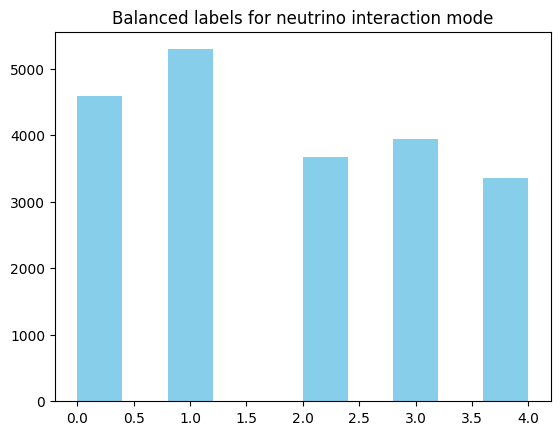

In [ ]:
## CHECKING IF THE LABELS ARE BALANCED 

plt.hist(int_mode_labels_b, color='skyblue')
plt.title('Balanced labels for neutrino interaction mode')

In [ ]:
## PREPARING THE DATA TO FEED INTO THE NEURAL NETWORK

# Shuffle
#int_mode_labels_b, int_mode_input_1, int_mode_input_2 = shuffle_data(int_mode_labels_b, int_mode_input_1, int_mode_input_2)

# expanding the dimensions of the images corresponding to the x-z view of the neutrino interaction
int_mode_input_1 = tf.expand_dims(int_mode_input_1, axis = 3)

# expanding the dimensions of the images corresponding to the y-z view of the neutrino interaction
int_mode_input_2 = tf.expand_dims(int_mode_input_2, axis = 3)

# training, testing and validation data
train_int_mode_input_1, test_int_mode_input_1, val_int_mode_input_1, train_int_mode_input_2, test_int_mode_input_2, val_int_mode_input_2, train_int_mode_labels_b, val_int_mode_labels_b, test_int_mode_labels_b = data(int_mode_input_1, int_mode_input_2, int_mode_labels_b, 0.8, 0.8)

# to use categorical cross entropy 
train_int_mode_labels_b = tf.keras.utils.to_categorical(train_int_mode_labels_b, 5)
test_int_mode_labels_b = tf.keras.utils.to_categorical(test_int_mode_labels_b, 5)
val_int_mode_labels_b = tf.keras.utils.to_categorical(val_int_mode_labels_b, 5)

In [ ]:

# Creates the CNN model for the x-z view of the neutrino interaction.
xz_input = Input(shape=np.shape(int_mode_input_1)[1:])
xz_model = conv_block(xz_input, np.shape(int_mode_input_1)[1:])

# Creates the CNN model for the y-z view of the neutrino interaction.
yz_input = Input(shape=np.shape(int_mode_input_1)[1:])
yz_model = conv_block(yz_input, np.shape(int_mode_input_1)[1:])

# Concatenates the two models 
conv = concatenate([xz_model, yz_model])

# Flattens the concatenated models 
conv = Flatten()(conv)
dense = Dense(24,                                                             
              activation = "relu")(conv)
# Dense layers connect all the neurons of one layer to the ones in the next layer 
dense = Dense(8,                                                            
              activation = "relu")(dense)                                     
dense = Dropout(0.3)(dense)                                                   

output = Dense(5,                                                            
                activation ="sigmoid")(dense)                                 

# creates the model using the two model inputs 
model_e5 = Model(inputs = [xz_input, yz_input], outputs = [output])

# compiles the final model
model_e5.compile(loss=tf.keras.losses.categorical_crossentropy, 
              optimizer='adam',                                               
              metrics=['accuracy'])          

model_e5.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_15 (InputLayer)          [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_44 (Conv2D)             (None, 100, 80, 16)  160         ['input_14[0][0]']               
                                                                                            

In [ ]:
# Monitoring val_loss, if there is no improvement after 5 epochs the model stops there and uses the weights of the last improvement
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",                      
                                        mode ="min",                               
                                        patience = 5,                              
                                        restore_best_weights = True)           

history_elec = model_e5.fit(x=[train_int_mode_input_1,train_int_mode_input_2],
                    y=train_int_mode_labels_b, batch_size=64, 
                    epochs=50,  
                    validation_data=([val_int_mode_input_1,val_int_mode_input_2],val_int_mode_labels_b),
                    callbacks =[earlystopping] )   

Epoch 1/50
209/209 [==============================] - 18s 79ms/step - loss: 1.2392 - accuracy: 0.3723 - val_loss: 4.9575 - val_accuracy: 0.0000e+00
Epoch 2/50
209/209 [==============================] - 15s 72ms/step - loss: 1.1347 - accuracy: 0.3783 - val_loss: 10.7394 - val_accuracy: 0.0000e+00
Epoch 3/50
209/209 [==============================] - 15s 72ms/step - loss: 1.1152 - accuracy: 0.3900 - val_loss: 10.1763 - val_accuracy: 5.9970e-04
Epoch 4/50
209/209 [==============================] - 15s 72ms/step - loss: 1.1073 - accuracy: 0.3974 - val_loss: 10.6434 - val_accuracy: 0.0111
Epoch 5/50
209/209 [==============================] - 15s 71ms/step - loss: 1.0971 - accuracy: 0.4008 - val_loss: 7.6648 - val_accuracy: 0.0114
Epoch 6/50
209/209 [==============================] - 15s 72ms/step - loss: 1.0878 - accuracy: 0.4057 - val_loss: 10.5562 - val_accuracy: 0.0090


Text(0.5, 1.0, 'Accuracy of neutrino interaction mode classifier')

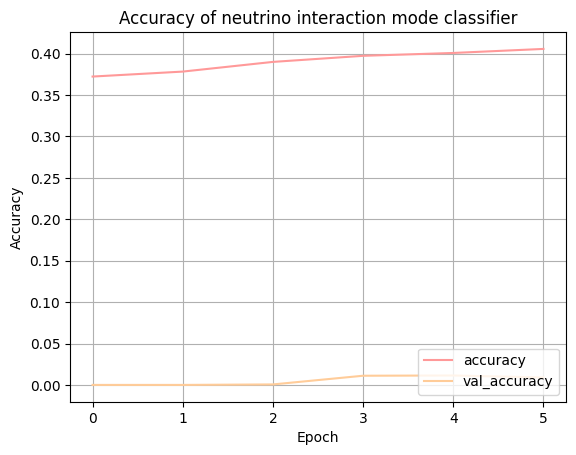

In [ ]:
## PLOTTING THE ACCURACY OF THE MODEL

plt.plot(history_elec.history['accuracy'], label='accuracy',c='#ff9999')
plt.plot(history_elec.history['val_accuracy'], label = 'val_accuracy',c='#ffcc99')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.title('Accuracy of neutrino interaction mode classifier')

Text(0.5, 1.0, 'Loss of neutrino interaction mode classifier')

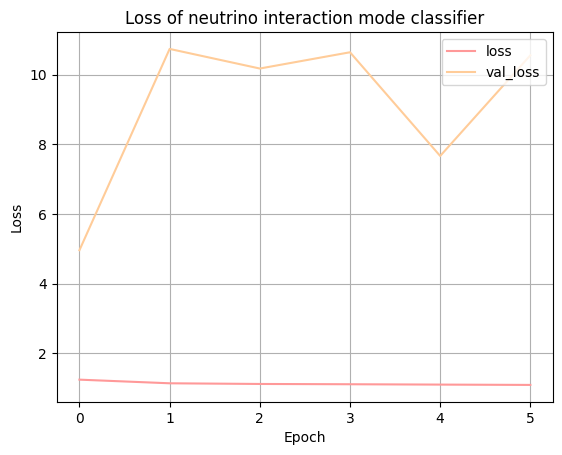

In [ ]:
## PLOTTING THE LOSS OF THE MODEL

plt.plot(history_elec.history['loss'], label='loss',c='#ff9999')
plt.plot(history_elec.history['val_loss'], label = 'val_loss',c='#ffcc99')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.title('Loss of neutrino interaction mode classifier')

In [ ]:
## EVALUATING THE ACCURACY AND LOSS OF THE MODEL 

test_loss, test_acc = model.evaluate([test_int_mode_input_1,test_int_mode_input_2],  test_int_mode_labels_b, verbose=2)

131/131 - 1s - loss: 1.6705 - accuracy: 0.0000e+00 - 1s/epoch - 11ms/step


# Extension Conclusions

In this study, four extensions to the neutrino interaction biclassifier were proposed and implemented using convolutional neural networks (CNNs). The first three extensions showed good results (70%) in determining the energy, classifying the flavor, and finding the ratio of lepton energy over neutrino energy. However, the fourth extension, which aimed to classify the interaction mode of neutrinos, showed poor results. This could potentially be due to the gradient exploding problem, but further investigation is required to confirm this. Nonetheless, the overall findings demonstrate the potential of using CNNs to solve complex problems in neutrino physics.